# Load libraries & data 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import log_loss, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold
from scipy.stats import boxcox, median_abs_deviation
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

### Load data

In [2]:
df_train = pd.read_csv("/input/playground-series-s3e5/train.csv", index_col = 0)
df_test = pd.read_csv("/input/playground-series-s3e5/test.csv", index_col = 0)
sub = pd.read_csv("/input/playground-series-s3e5/sample_submission.csv",index_col = 0)

### Set Project Parameters 

In [3]:
target = "quality" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = True
DISTRIBUTION = True
OUTLIERS= True

# Feature engineering and model training options
ADD_DATA = True
THRESHOLD = 0.4 # For CV model removal
SMOTE_over = False
EPOCHS= 10000

# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

### Additional data

In [4]:
if ADD_DATA:
    add_data = pd.read_csv('/input/wine-quality-dataset/WineQT.csv', index_col = "Id")

#     df_train['is_generated'] = 1
#     df_test['is_generated'] = 1
#     add_data['is_generated'] = 0

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.0             0.500         0.39             2.2      0.073   
1               9.3             0.300         0.73             2.3      0.092   
2               7.1             0.510         0.03             2.1      0.059   
3               8.1             0.870         0.22             2.6      0.084   
4               8.5             0.360         0.30             2.3      0.079   
...             ...               ...          ...             ...        ...   
3194            6.3             0.510         0.13             2.3      0.076   
3195            6.8             0.620         0.08             1.9      0.068   
3196            6.2             0.600         0.08             2.0      0.090   
3197            5.9             0.550         0.10             2.2      0.062   
3198            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
3194                 29.0                  40.0  0.99574  3.42       0.75   
3195                 28.0                  38.0  0.99651  3.42       0.82   
3196                 32.0                  44.0  0.99490  3.45       0.58   
3197                 39.0                  51.0  0.99512  3.52       0.76   
3198                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality  
0        12.1        6  
1        12.8        6  
2        11.3        7  
3         9.8        5  
4         9.5        6  
...       ...      ...  
3194     11.0        6  
3195      9.5        6  
3196     10.5        5  
3197     11.2        6  
3198     10.2        5  

[3199 rows x 12 columns]

# Basic Analysis

In [5]:
print("Initial look at the data")
df_train.head()

Initial look at the data


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.0              0.50         0.39             2.2      0.073   
1            9.3              0.30         0.73             2.3      0.092   
2            7.1              0.51         0.03             2.1      0.059   
3            8.1              0.87         0.22             2.6      0.084   
4            8.5              0.36         0.30             2.3      0.079   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 30.0                  39.0  0.99572  3.33       0.77   
1                 30.0                  67.0  0.99854  3.32       0.67   
2                  3.0                  12.0  0.99660  3.52       0.73   
3                 11.0                  65.0  0.99730  3.20       0.53   
4                 10.0                  45.0  0.99444  3.20       1.36   

   alcohol  quality  
0     12.1        6  
1     12.8        6  
2     11.3        7  
3      9.8        5  
4      9.5        6

In [6]:
print("First 5 rows of Target")
display(df_train[target].head())

First 5 rows of Target


0    6
1    6
2    7
3    5
4    6
Name: quality, dtype: int64

In [7]:
print("Unique datatypes:\n",df_train.dtypes.unique())

Unique datatypes:
 [dtype('float64') dtype('int64')]


In [8]:
print("Column information:\n")
df_train.info()

Column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3199 non-null   float64
 1   volatile acidity      3199 non-null   float64
 2   citric acid           3199 non-null   float64
 3   residual sugar        3199 non-null   float64
 4   chlorides             3199 non-null   float64
 5   free sulfur dioxide   3199 non-null   float64
 6   total sulfur dioxide  3199 non-null   float64
 7   density               3199 non-null   float64
 8   pH                    3199 non-null   float64
 9   sulphates             3199 non-null   float64
 10  alcohol               3199 non-null   float64
 11  quality               3199 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 300.0 KB


In [9]:
print("Statistical values of features\n")
df_train.describe()

Statistical values of features



fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3199.000000       3199.000000  3199.000000     3199.000000   
mean        8.345858          0.528936     0.266239        2.446499   
std         1.720511          0.175484     0.191294        1.065161   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

        chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3199.00000          3199.000000           3199.000000  3199.000000   
mean      0.08367            16.477024             48.049859     0.996742   
std       0.03414            10.115222             32.930681     0.001863   
min       0.01200             1.000000              6.000000     0.990070   
25%       0.07100             7.000000             22.000000     0.995580   
50%       0.07900            15.000000             42.000000     0.996700   
75%       0.09000            23.000000             64.000000     0.997800   
max       0.61100            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  3199.000000  3199.000000  3199.000000  3199.000000  
mean      3.310728     0.647168    10.424669     5.698031  
std       0.147582     0.150524     1.048119     0.836977  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.200000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.100000     6.000000  
75%       3.390000     0.720000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [10]:
print("Null values: \nTrain:", df_train.isnull().sum().sum(), "\nTest:",df_test.isnull().sum().sum())

Null values: 
Train: 0 
Test: 0


In [11]:
print("Number of Duplicates in train:",df_train.duplicated().sum())
print("Number of Duplicates in test:",df_test.duplicated().sum())

Number of Duplicates in train: 125
Number of Duplicates in test: 0


In [12]:
print("Duplicated targets:\n", df_train[df_train.duplicated()][target].value_counts())

Duplicated targets:
 6    53
5    50
7    21
8     1
Name: quality, dtype: int64


## Target Analysis



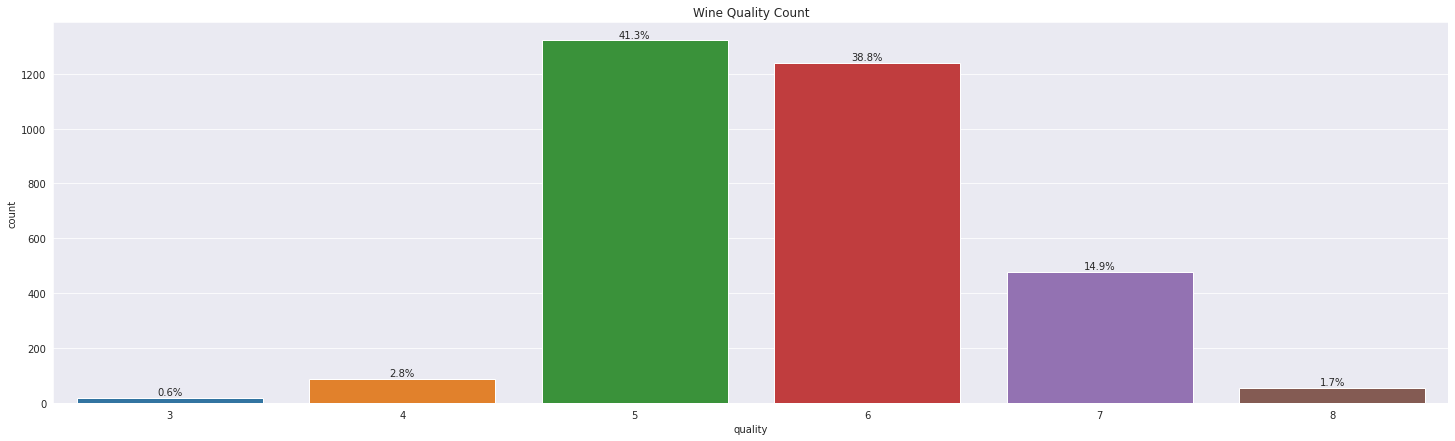

In [13]:
fig, ax = plt.subplots(figsize = (25,7))
sns.countplot(x= df_train[target])
plt.title("Wine Quality Count")

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

In [14]:
df_train[target].unique()

array([6, 7, 5, 4, 8, 3])

# Distribution & Skewness

In [15]:
numerical = [col for col in df_train.select_dtypes(["int64", "float64","int32", "float32"]).columns if col not in [target]]
categorical = [col for col in df_train.select_dtypes("object").columns if col!=target]
print("Numerical Columns:\n",numerical)
print("\n")
print("Categorical Columns:\n",categorical)

Numerical Columns:
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Categorical Columns:
 []


## Skewness & Kurtosis

In [17]:
skew_df = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



density                 0.147377
pH                      0.232995
citric acid             0.271634
volatile acidity        0.697208
alcohol                 0.789138
free sulfur dioxide     0.826404
fixed acidity           0.991695
total sulfur dioxide    1.308484
sulphates               2.086318
residual sugar          4.288313
chlorides               7.016995
dtype: float64

In [18]:
kurtosis_df = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



citric acid             -0.821532
alcohol                 -0.097520
pH                       0.542226
free sulfur dioxide      0.686953
density                  0.765202
fixed acidity            0.930621
volatile acidity         1.160855
total sulfur dioxide     2.678366
sulphates               10.576394
residual sugar          30.692751
chlorides               76.649309
dtype: float64

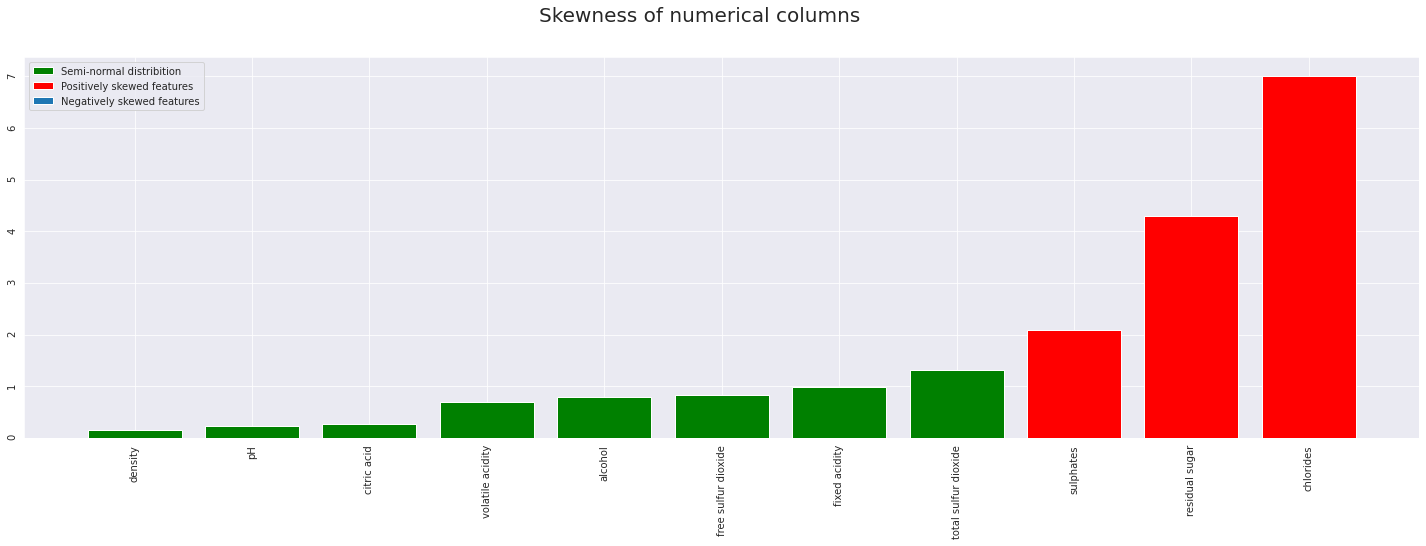

In [19]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[(skew_df<2)& (skew_df>-2)].index, height = skew_df[(skew_df<2)& (skew_df>-2)], color = "g", label= "Semi-normal distribition")
ax.bar(x = skew_df[skew_df>2].index, height = skew_df[skew_df>2], color = "r", label = "Positively skewed features")
ax.bar(x = skew_df[skew_df<-2].index, height = skew_df[skew_df<-2], color = "b", label = "Negatively skewed features")
ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

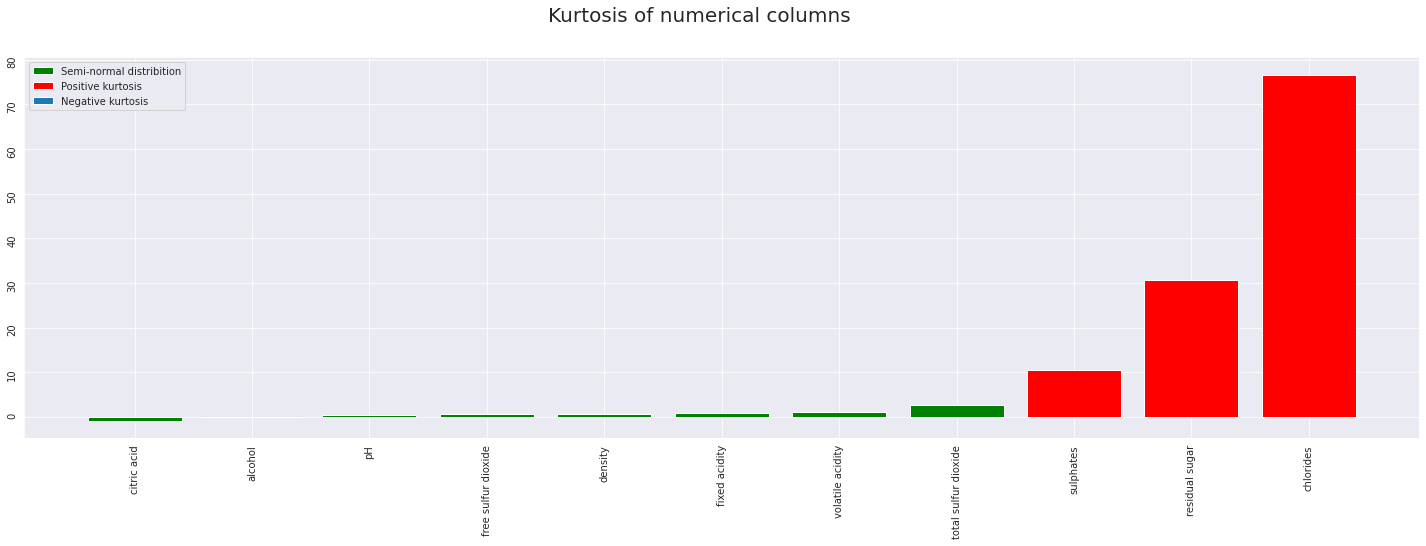

In [20]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)].index, height = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)], color = "g", label= "Semi-normal distribition")
ax.bar(x = kurtosis_df[kurtosis_df>7].index, height = kurtosis_df[kurtosis_df>7], color = "r", label = "Positive kurtosis")
ax.bar(x = kurtosis_df[kurtosis_df<-7].index, height = kurtosis_df[kurtosis_df<-7], color = "b",  label = "Negative kurtosis")
ax.legend()
fig.suptitle("Kurtosis of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

# Distribution Transformations: 
* Log transform 
* Scaling (Quantile) 
* BoxCox 
* Cube root / Square root

In [21]:
non_dist_cols = ['sulphates', 'residual sugar', 'chlorides']

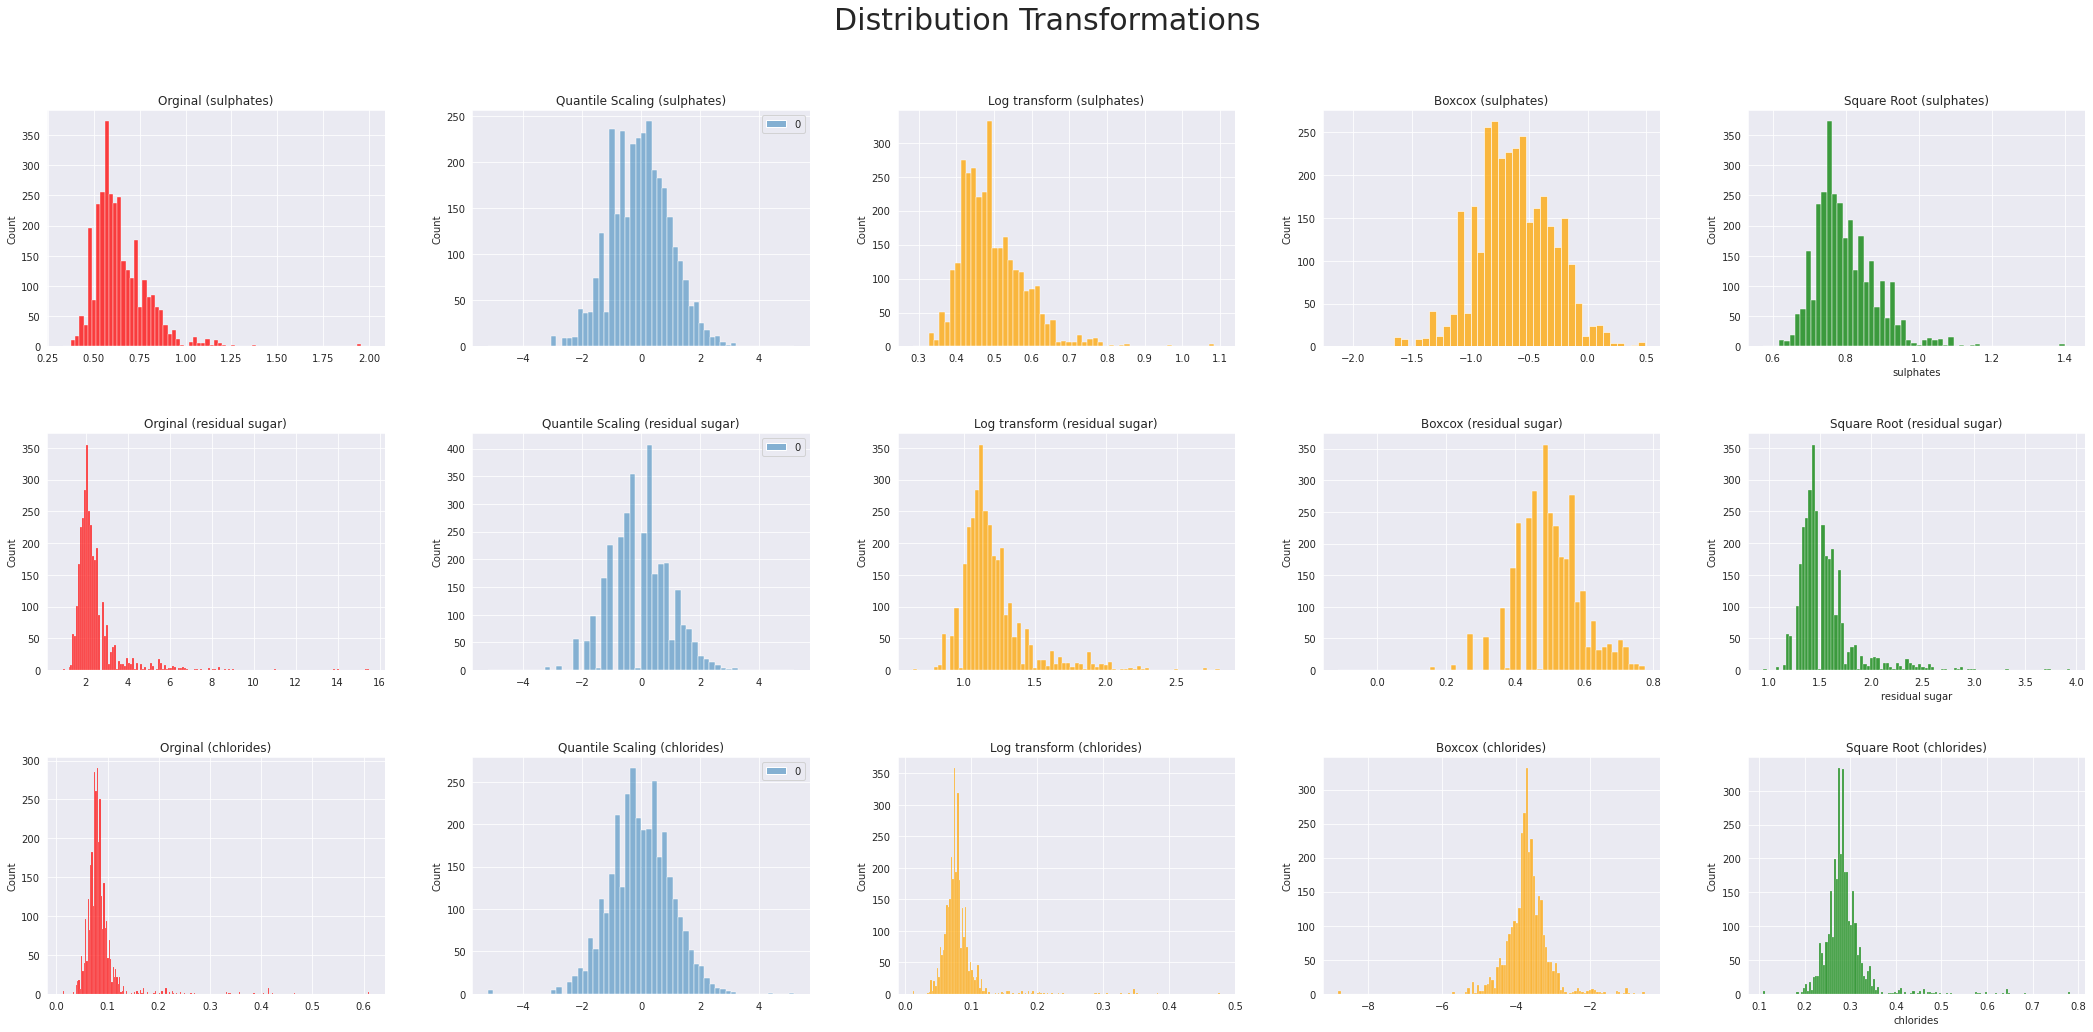

In [22]:
fig,ax = plt.subplots(len(non_dist_cols),5, figsize = (30,15))
for i,col in enumerate(non_dist_cols):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(df_train[[col]])

    sns.histplot(x= df_train[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(df_train[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(df_train[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(df_train[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

# Correlation & Mututal Information 

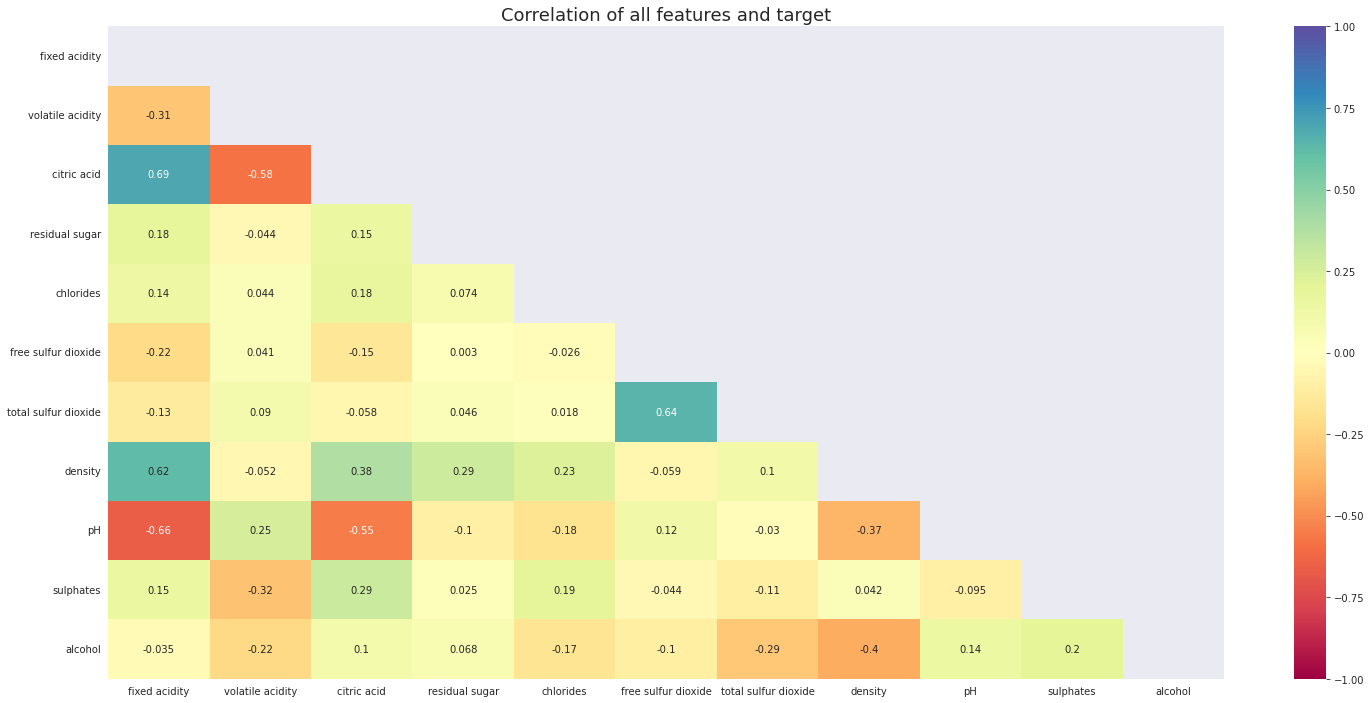

In [23]:
plt.figure(figsize = (25,12))

corr = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

In [24]:
 # feature selection
def select_features(df):
    df_trn = pd.get_dummies(df_train,drop_first =True) #onehotencoding needed for categorical columns 
    X_train, X_test, y_train, y_test = train_test_split(df_trn.drop(target,axis =1), df_trn[target], test_size=0.33, random_state=1) 
    
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    columns = X_train.columns
    return X_train_fs, X_test_fs, fs, columns 

# feature selection
X_train_fs, X_test_fs, fs, columns = select_features(df_train)

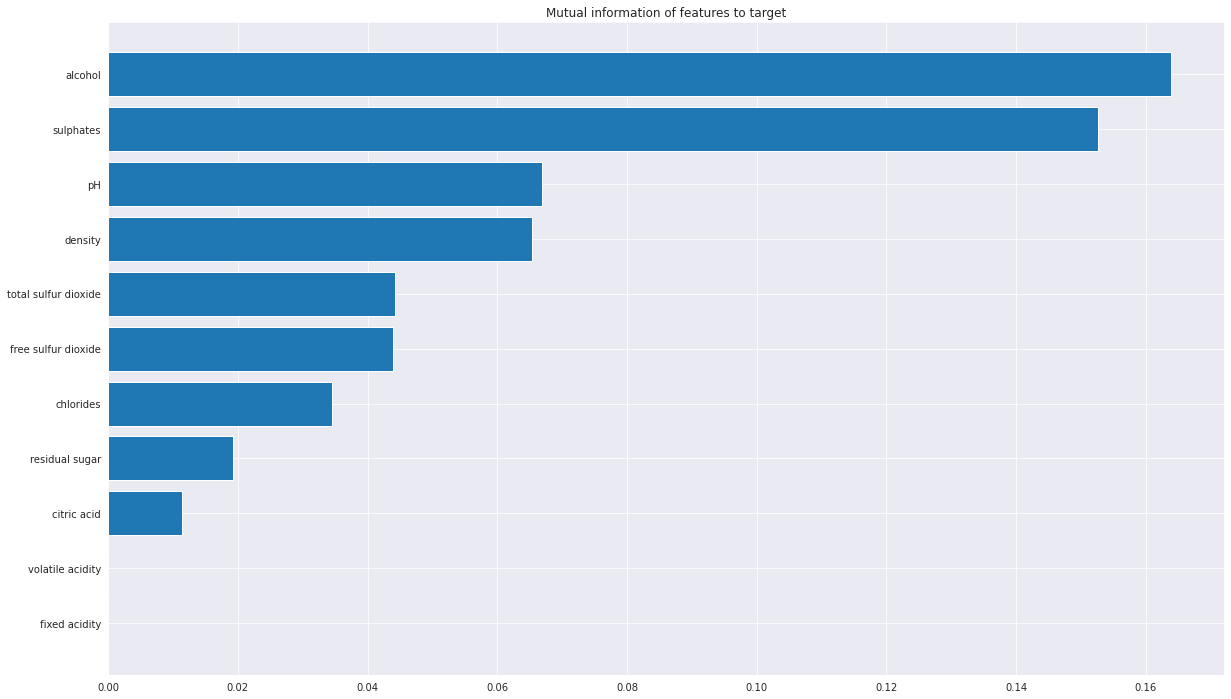

In [25]:
selected_feats = pd.DataFrame(fs.scores_, index = columns).sort_values(by = 0 , ascending = True)

fig,ax = plt.subplots(figsize =(20,12))
plt.barh(y =columns, width= selected_feats[0])
plt.title("Mutual information of features to target")
plt.show()

* Certain features are highly dependent on our Target(i.e. Alcohol).
* There is little to no mutual information for 'fixed acidity' and 'volatile acidity' and could be potential for removal.

# Outliers / Distribution

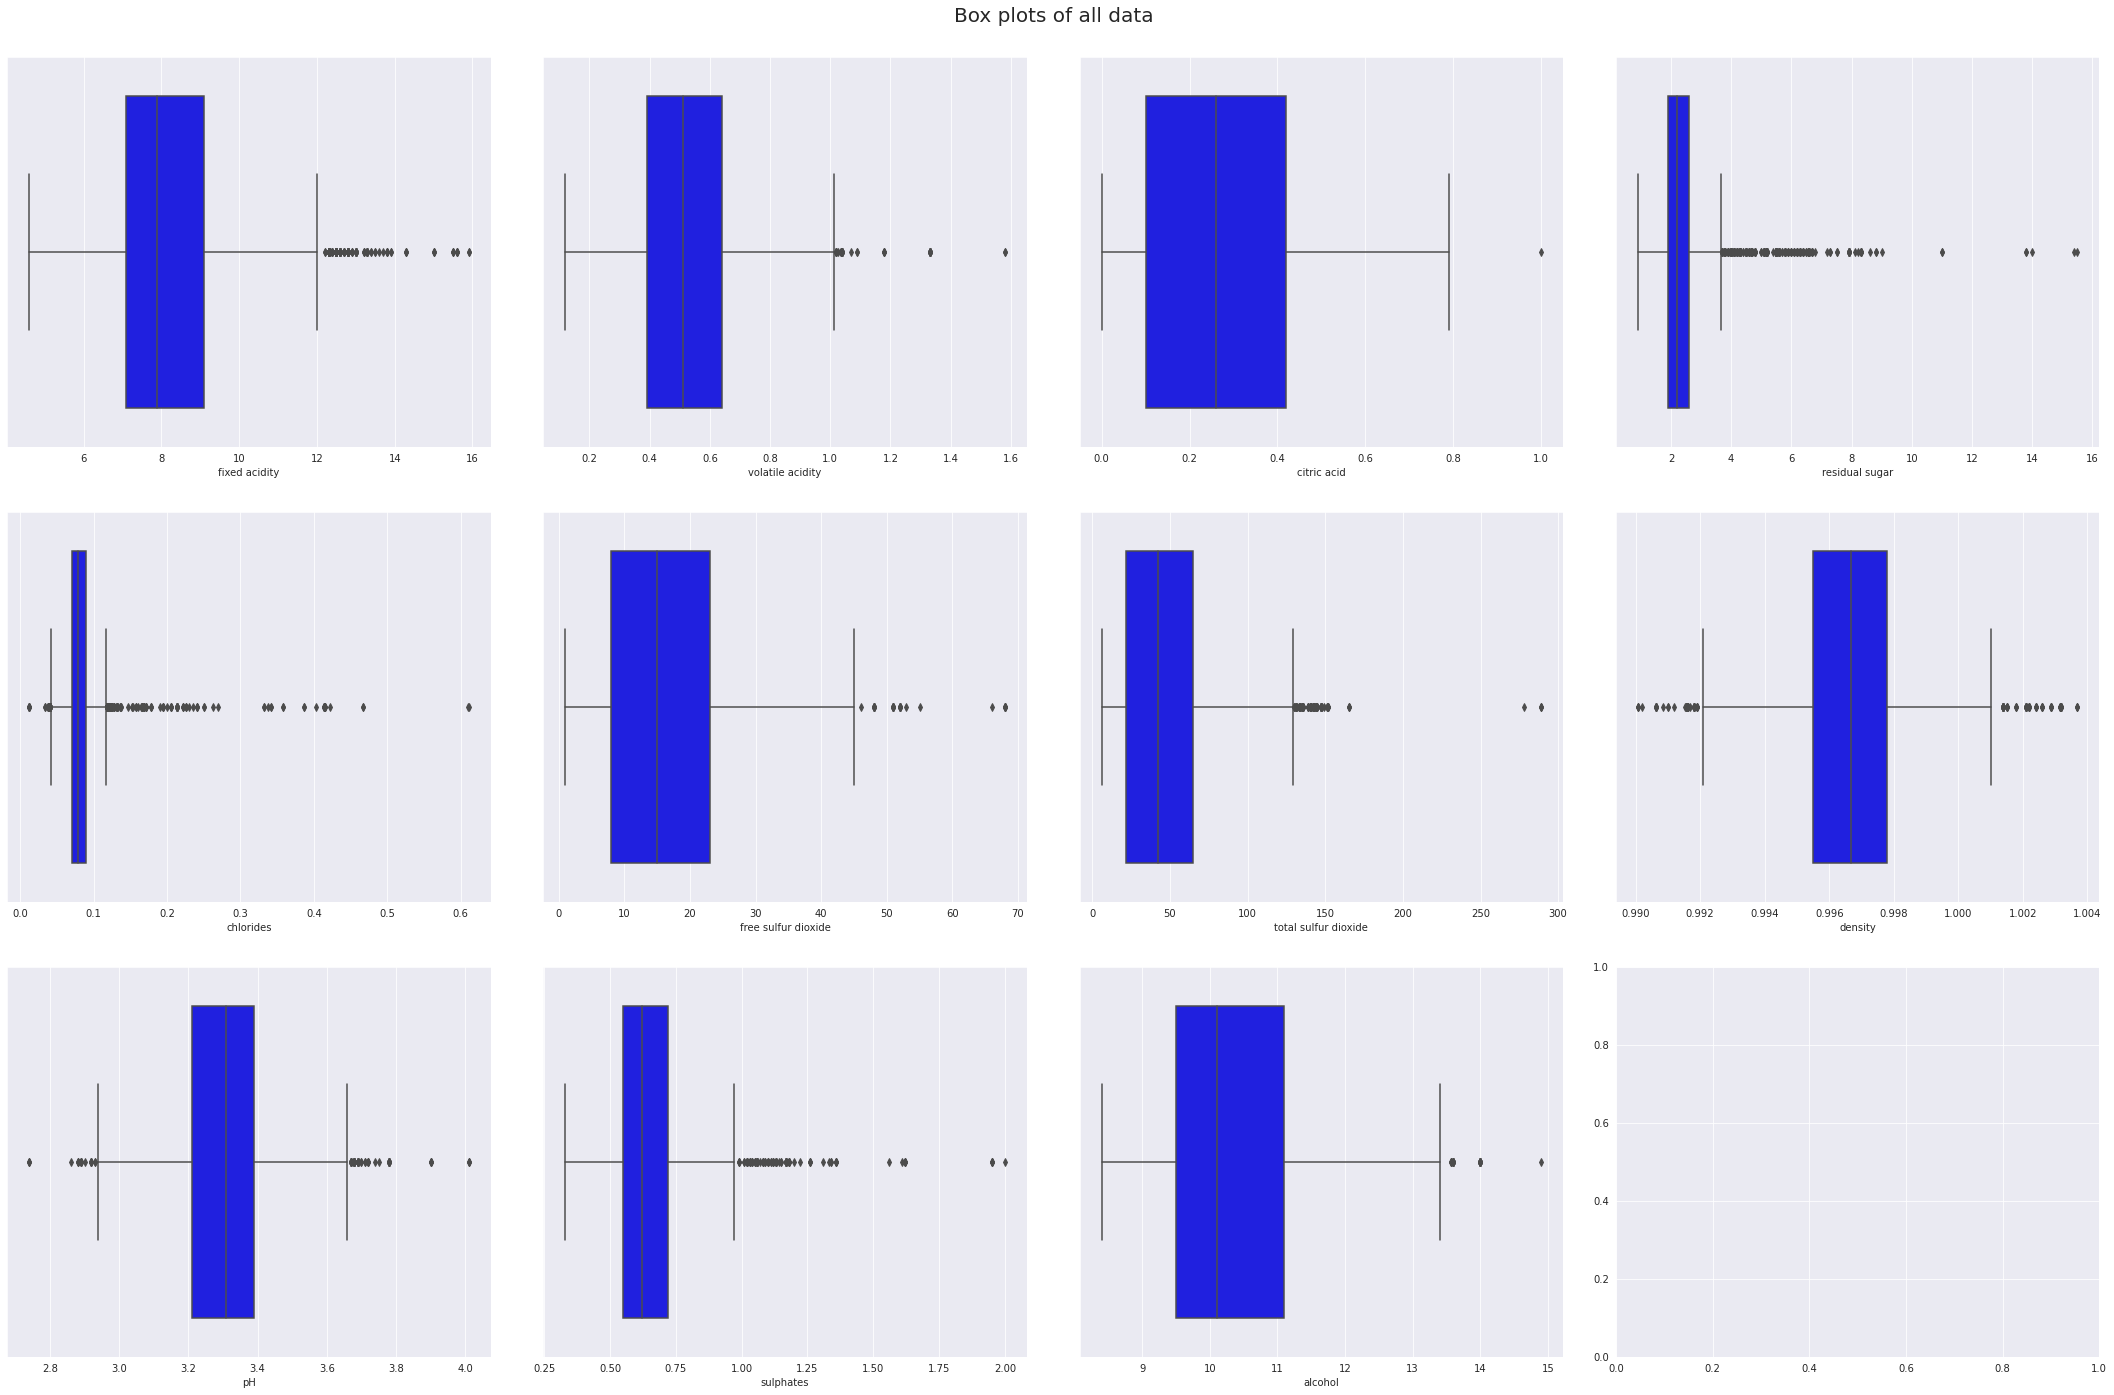

In [26]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (30,20))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.boxplot(ax = ax[i], x = pd.concat((df_train.drop(target,axis =1), df_test), axis =0)[col], color= "blue")

fig.suptitle("Box plots of all data ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [27]:
from scipy.stats import zscore
df_zscores = pd.concat((df_train.drop(target,axis =1), df_test), axis =0)[numerical].apply(zscore)
print("Sample z-scores by feature:\n")
df_zscores.head()

Sample z-scores by feature:



fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.207198         -0.156614     0.645856       -0.231771  -0.310616   
1       0.555885         -1.293643     2.439005       -0.134110   0.281888   
2      -0.735486         -0.099763    -1.252772       -0.329432  -0.747198   
3      -0.148500          1.946889    -0.250718        0.158873   0.032412   
4       0.086295         -0.952535     0.171199       -0.134110  -0.123510   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             1.321707             -0.284651 -0.540464  0.129168   0.841402   
1             1.321707              0.566701  0.983593  0.060545   0.156235   
2            -1.357988             -1.105597 -0.064872  1.432988   0.567335   
3            -0.564005              0.505890  0.313440 -0.762920  -0.802999   
4            -0.663253             -0.102218 -1.232235 -0.762920   4.883889   

    alcohol  
0  1.594033  
1  2.265892  
2  0.826195  
3 -0.613503  
4 -0.901443

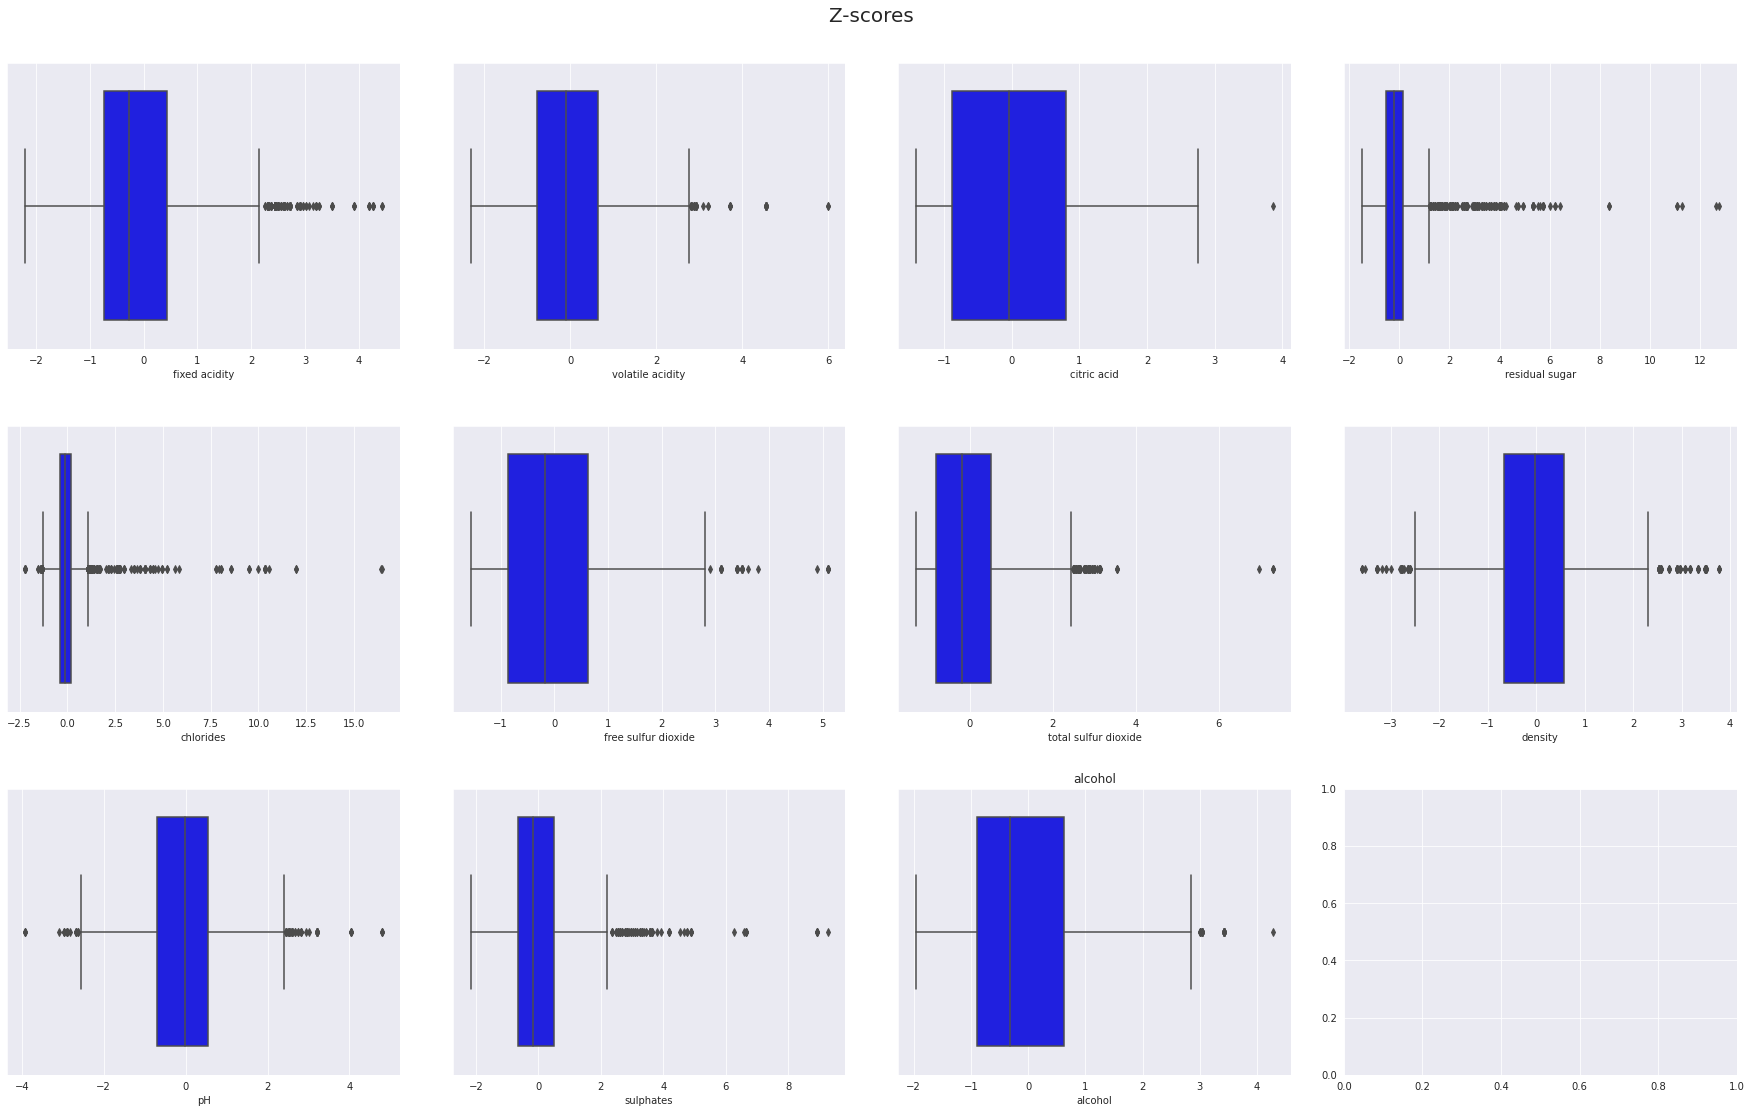

In [28]:
fig,ax = plt.subplots(int(np.ceil(len(numerical)/4)),4,figsize = (25,16))
ax = np.ravel(ax)

for i,col in enumerate(df_zscores.columns):
    sns.boxplot(ax = ax[i], x = df_zscores[col], color= "blue")
ax[i].set_title(f"{col}")
fig.suptitle("Z-scores ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [29]:
outliers = ['fixed acidity', 'residual sugar', 'chlorides','pH' ,'sulphates']

In [30]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)

In [31]:
# Drop duplicates
df_trn.drop_duplicates(inplace = True,ignore_index  = True)
print(df_trn.duplicated().sum())

0


## Encoding

In [32]:
if len(categorical)> 0:
    df_trn = pd.get_dummies(df_train,drop_first =True)
    df_tst = pd.get_dummies(df_test,drop_first =True)
df_trn.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.0              0.50         0.39             2.2      0.073   
1            9.3              0.30         0.73             2.3      0.092   
2            7.1              0.51         0.03             2.1      0.059   
3            8.1              0.87         0.22             2.6      0.084   
4            8.5              0.36         0.30             2.3      0.079   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 30.0                  39.0  0.99572  3.33       0.77   
1                 30.0                  67.0  0.99854  3.32       0.67   
2                  3.0                  12.0  0.99660  3.52       0.73   
3                 11.0                  65.0  0.99730  3.20       0.53   
4                 10.0                  45.0  0.99444  3.20       1.36   

   alcohol  quality  
0     12.1        6  
1     12.8        6  
2     11.3        7  
3      9.8        5  
4      9.5        6

#### Fix target class: Wine Quality 

In [33]:
#map the classes to start from 0
df_trn[target] = df_trn[target].map({3:0,
                    4:1,
                    5:2,
                    6:3,
                    7:4,
                    8:5})

## Correlation reduction 

In [34]:
pca_cols = ["pH","fixed acidity"]
pca_ = PCA(n_components=1 ,whiten= False)
df_trn["pca_1"] = pca_.fit_transform(df_trn[pca_cols])
df_tst["pca_1"] = pca_.fit_transform(df_tst[pca_cols])

for cols in pca_cols:
    for df in [df_trn,df_tst]:
        df.drop(cols, axis =1, inplace = True)

df_trn

volatile acidity  citric acid  residual sugar  chlorides  \
0                0.500         0.39             2.2      0.073   
1                0.300         0.73             2.3      0.092   
2                0.510         0.03             2.1      0.059   
3                0.870         0.22             2.6      0.084   
4                0.360         0.30             2.3      0.079   
...                ...          ...             ...        ...   
3069             0.510         0.13             2.3      0.076   
3070             0.620         0.08             1.9      0.068   
3071             0.600         0.08             2.0      0.090   
3072             0.550         0.10             2.2      0.062   
3073             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density  sulphates  alcohol  \
0                    30.0                  39.0  0.99572       0.77     12.1   
1                    30.0                  67.0  0.99854       0.67     12.8   
2                     3.0                  12.0  0.99660       0.73     11.3   
3                    11.0                  65.0  0.99730       0.53      9.8   
4                    10.0                  45.0  0.99444       1.36      9.5   
...                   ...                   ...      ...        ...      ...   
3069                 29.0                  40.0  0.99574       0.75     11.0   
3070                 28.0                  38.0  0.99651       0.82      9.5   
3071                 32.0                  44.0  0.99490       0.58     10.5   
3072                 39.0                  51.0  0.99512       0.76     11.2   
3073                 32.0                  44.0  0.99547       0.71     10.2   

      quality     pca_1  
0           3 -0.340322  
1           3  0.958033  
2           4 -1.249903  
3           2 -0.232881  
4           3  0.166432  
...       ...       ...  
3069        3 -2.042675  
3070        3 -1.543533  
3071        2 -2.144260  
3072        3 -2.447844  
3073        2 -2.450772  

[3074 rows x 11 columns]

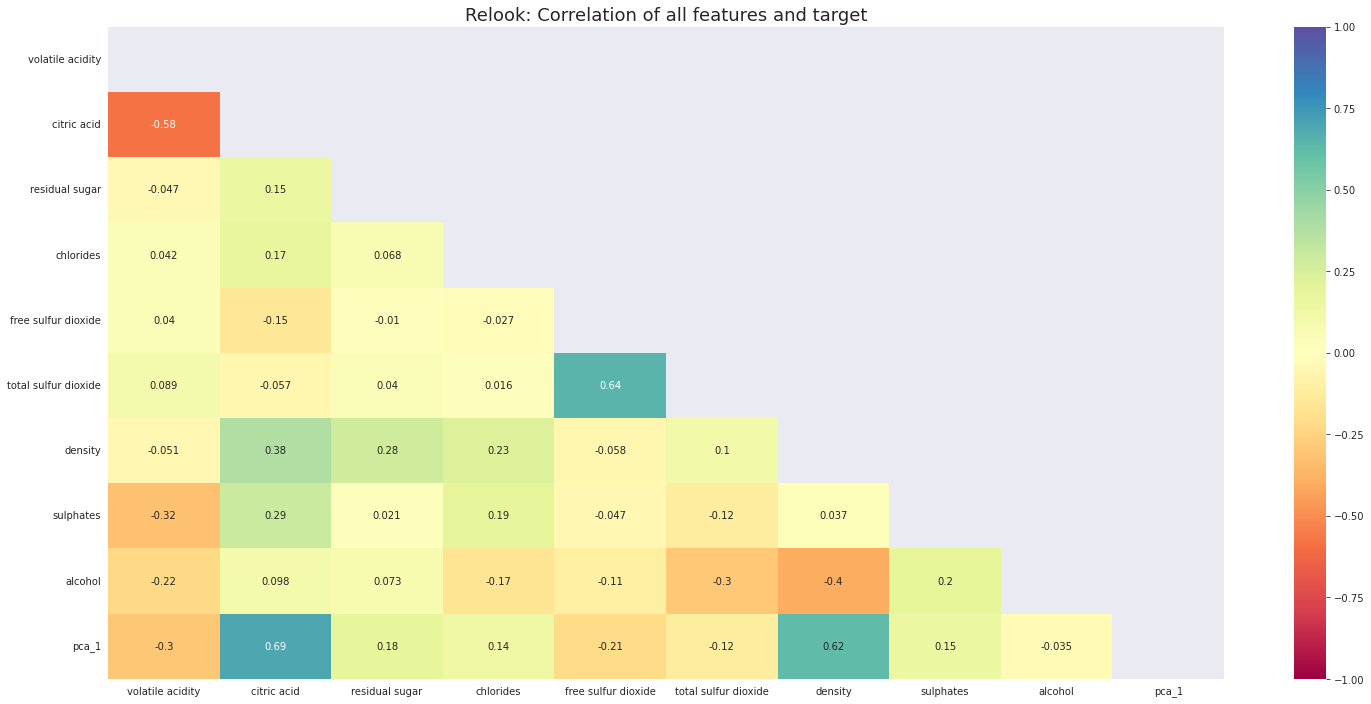

In [35]:
plt.figure(figsize = (25,12))
corr = pd.concat((df_trn.drop(target,axis =1), df_tst), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Relook: Correlation of all features and target", fontsize= 18)
plt.show()

## Split

In [36]:
X = df_trn.drop([target],axis =1)
y = df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Basic Modelling 

In [37]:
def kappa_score(dy_true, dy_pred):
    pred_labels = dy_pred.reshape(len(np.unique(dy_true)),-1).argmax(axis=0)
    
    ks = cohen_kappa_score(dy_true, pred_labels, weights ='quadratic' )
    is_higher_better = True

    return "kappa_score", ks, is_higher_better

In [38]:
# Note: scale_pos_weight is total majoriity / total minority class ==1477/200
# class_pos_weight =   (len(df_trn) - sum(df_trn[target]))/sum(df_trn[target])
# print("scale_pos_weight:",class_pos_weight)

print("skew columns:\n", non_dist_cols)
outliers = [col for col in outliers if col not in non_dist_cols + pca_cols]
print("outliers:\n", outliers)
scaled_cols = [col for col in df_trn.drop(target,axis =1).columns if col not in outliers + non_dist_cols+pca_cols]
print("scaled_cols:\n", scaled_cols) 

if len(scaled_cols)==0:
    SCALING = False

skew columns:
 ['sulphates', 'residual sugar', 'chlorides']
outliers:
 []
scaled_cols:
 ['volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'alcohol', 'pca_1']


State our base model paramaters 

In [39]:
lgb_params ={'objective': 'multiclassova',#multiclassova multiclass
             "metric":"multi_logloss", 
             "boosting": "gbdt",#"dart",gbdt
             'num_class': 6,
             'is_unbalanced' : True,
#              'lambda_l1': 1.0050418664783436e-08, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
              'feature_fraction': 0.8247273276668773,
              'bagging_fraction': 0.5842711778104962,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 8,
               'class_weight': 'balanced', #'balanced',     weights     
             'n_estimators':EPOCHS,
             'learning_rate':0.01,
            'device':'cpu'}

In [40]:
model= lgb.LGBMClassifier(**lgb_params)

X_train_s = X_train.copy(deep= True)
X_test_s = X_test.copy(deep= True)
test_temp = df_tst.copy(deep= True)
y_train_s = y_train.copy(deep= True)
X_temp = X.copy(deep = True)

model.fit(X_train_s,y_train_s,
          eval_set=[(X_test_s,y_test)],
          eval_metric=kappa_score,
          callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])

y_preds = model.predict_proba(X_test_s)
trn_preds_base = model.predict_proba(X_temp)
test_base = model.predict_proba(test_temp)

score_trn =cohen_kappa_score(y, trn_preds_base.argmax(axis =1), weights ='quadratic' )
score_val = cohen_kappa_score(y_test, y_preds.argmax(axis =1), weights ='quadratic' )

print("\nTrn kappa:",score_trn)
print("Val kappa:",score_val)
print("Val logloss", log_loss(y,trn_preds_base))

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 1.32783	valid_0's kappa_score: 0.466915

Trn kappa: 0.6410384282469823
Val kappa: 0.46691476880179517
Val logloss 1.067233605990234


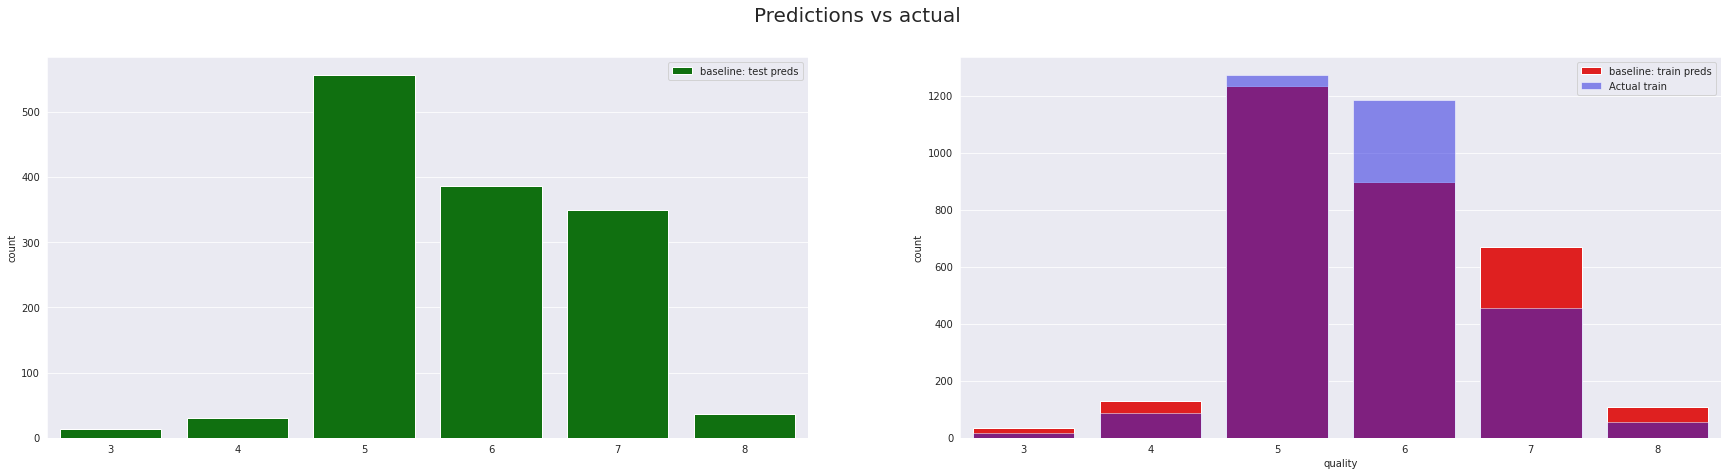

In [41]:
fig, ax = plt.subplots(1,2, figsize = (30,7))
sns.countplot(x =test_base.argmax(axis =1)+3, label = f"baseline: test preds", color ='green', ax= ax[0])
sns.countplot(x =trn_preds_base.argmax(axis =1)+3, label = f"baseline: train preds", color ='red', ax= ax[1])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[1])
ax[0].legend()
ax[1].legend()
plt.suptitle("Predictions vs actual", fontsize = 20)
plt.show()

# Partial Dependency Plots 

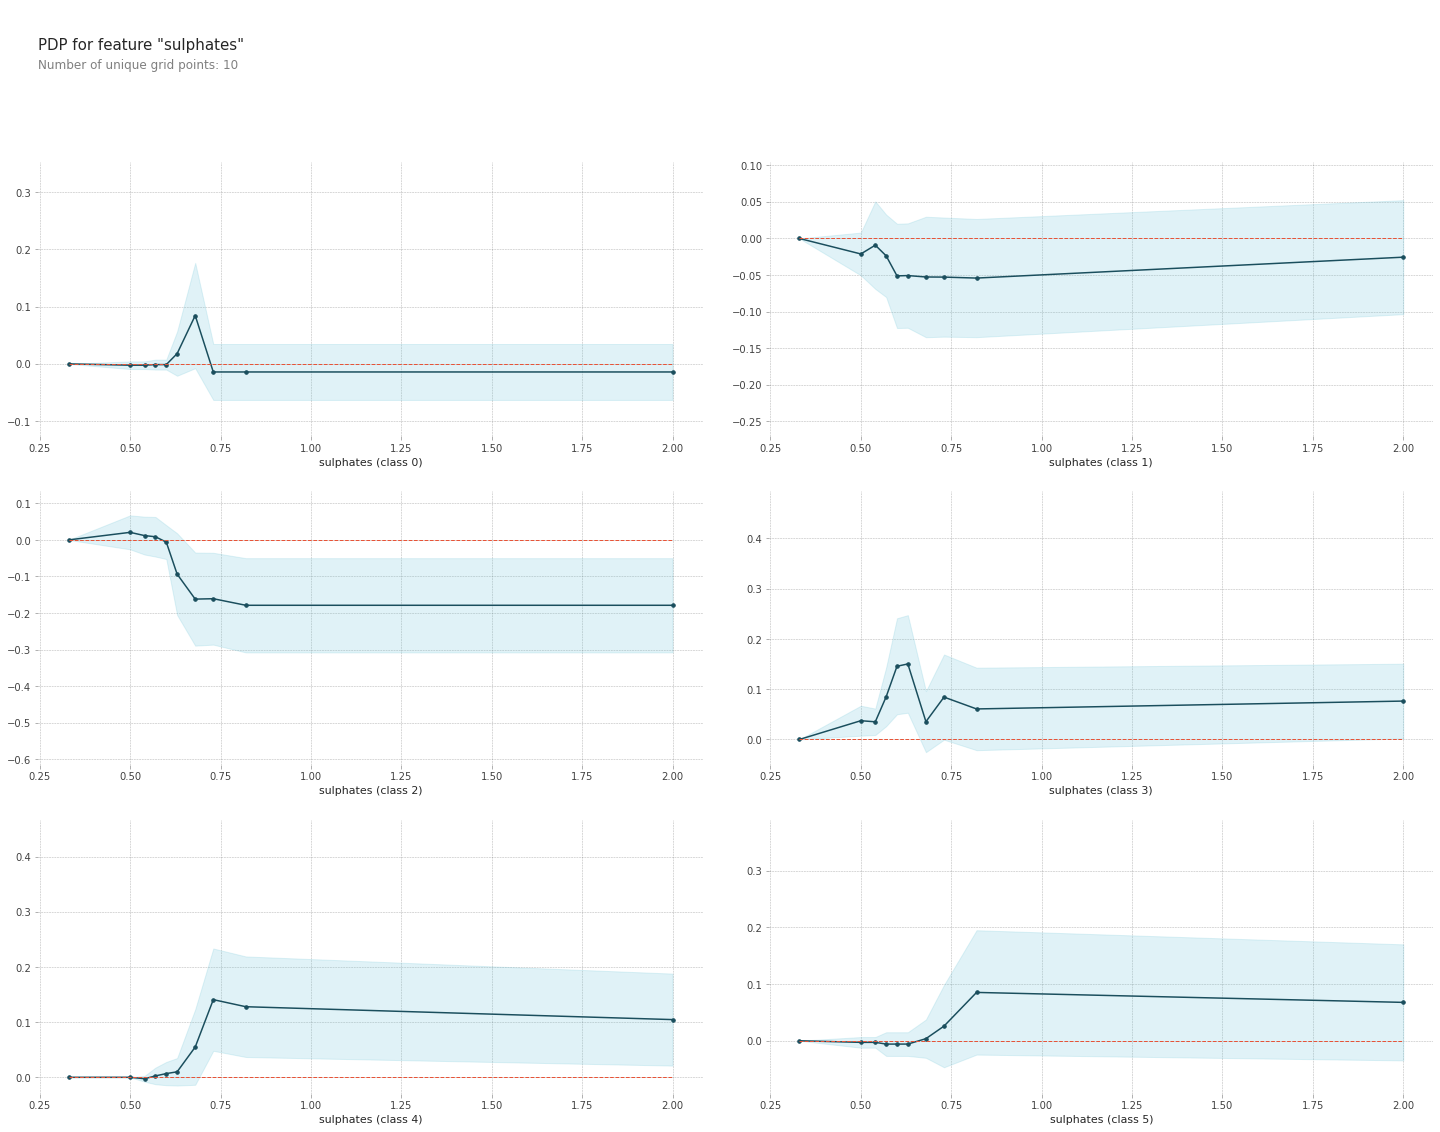

In [42]:
from pdpbox import pdp, get_dataset, info_plots
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_s
                           , model_features=X_train_s.columns
                           , feature='sulphates')
pdp.pdp_plot(pdp_dist, feature_name='sulphates',figsize =(25,20))
plt.tight_layout()
plt.show()

# Feature importance 




## 1. Intrinsic model feature importance

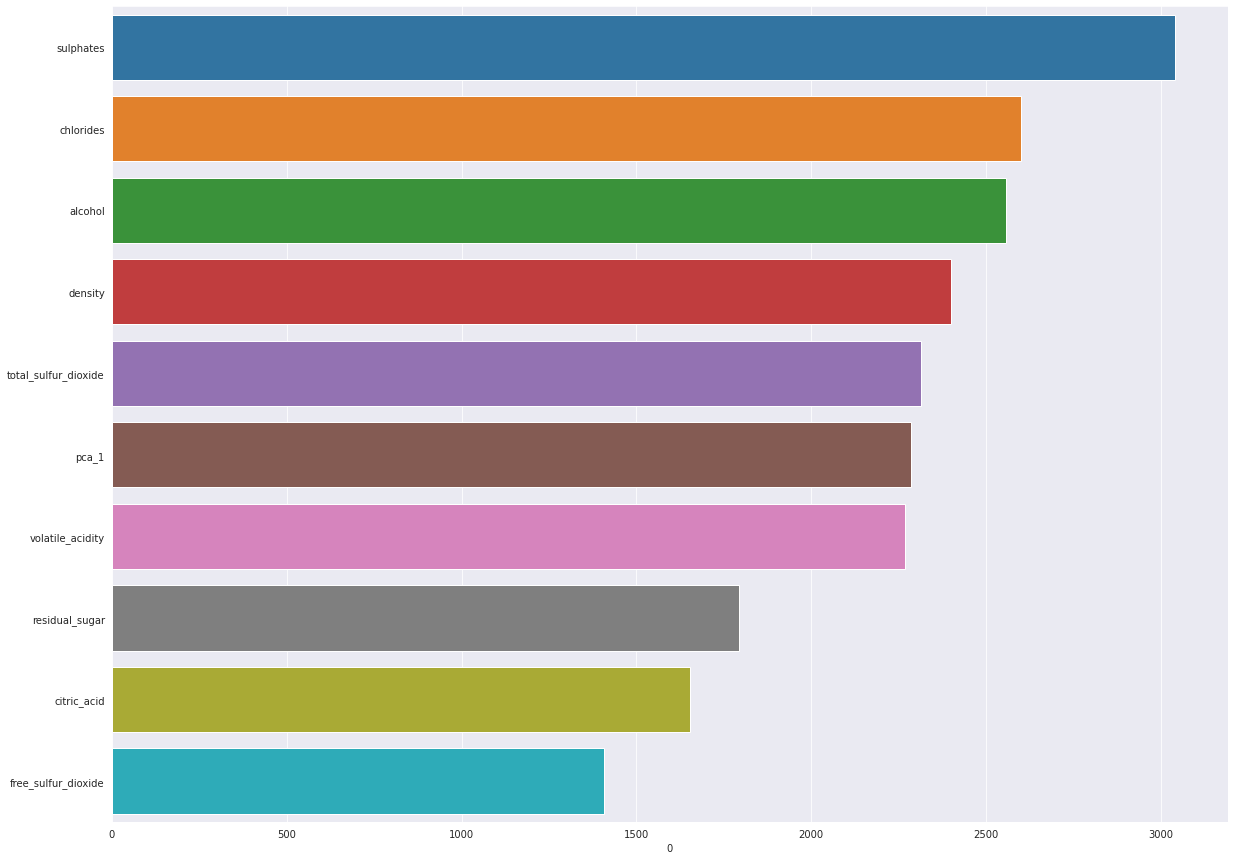

In [43]:
importances = pd.DataFrame(data = model.feature_importances_, index = model.feature_name_).sort_values(ascending = False , by =0)

plt.figure(figsize = (20,15))
sns.barplot(x = importances[0], y= importances.index)
plt.show()

## 2. Shap values 


In [44]:
shap.initjs() # for visualization 

#Get Shap values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_s)



### Summary Plot


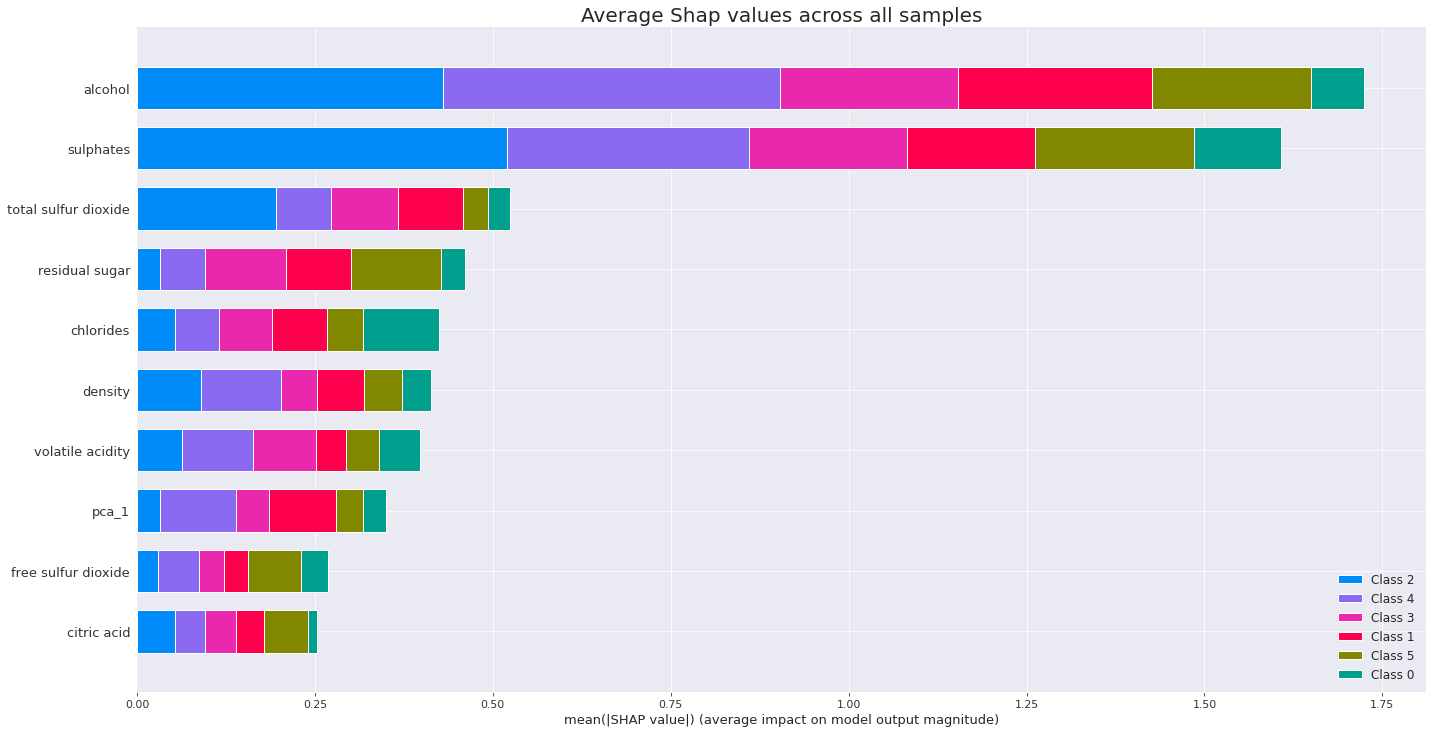

In [45]:
shap.summary_plot(shap_values, X_test_s,max_display = 400, plot_size = [20,10], show= False)
plt.title("Average Shap values across all samples", fontsize = 20)
plt.show()

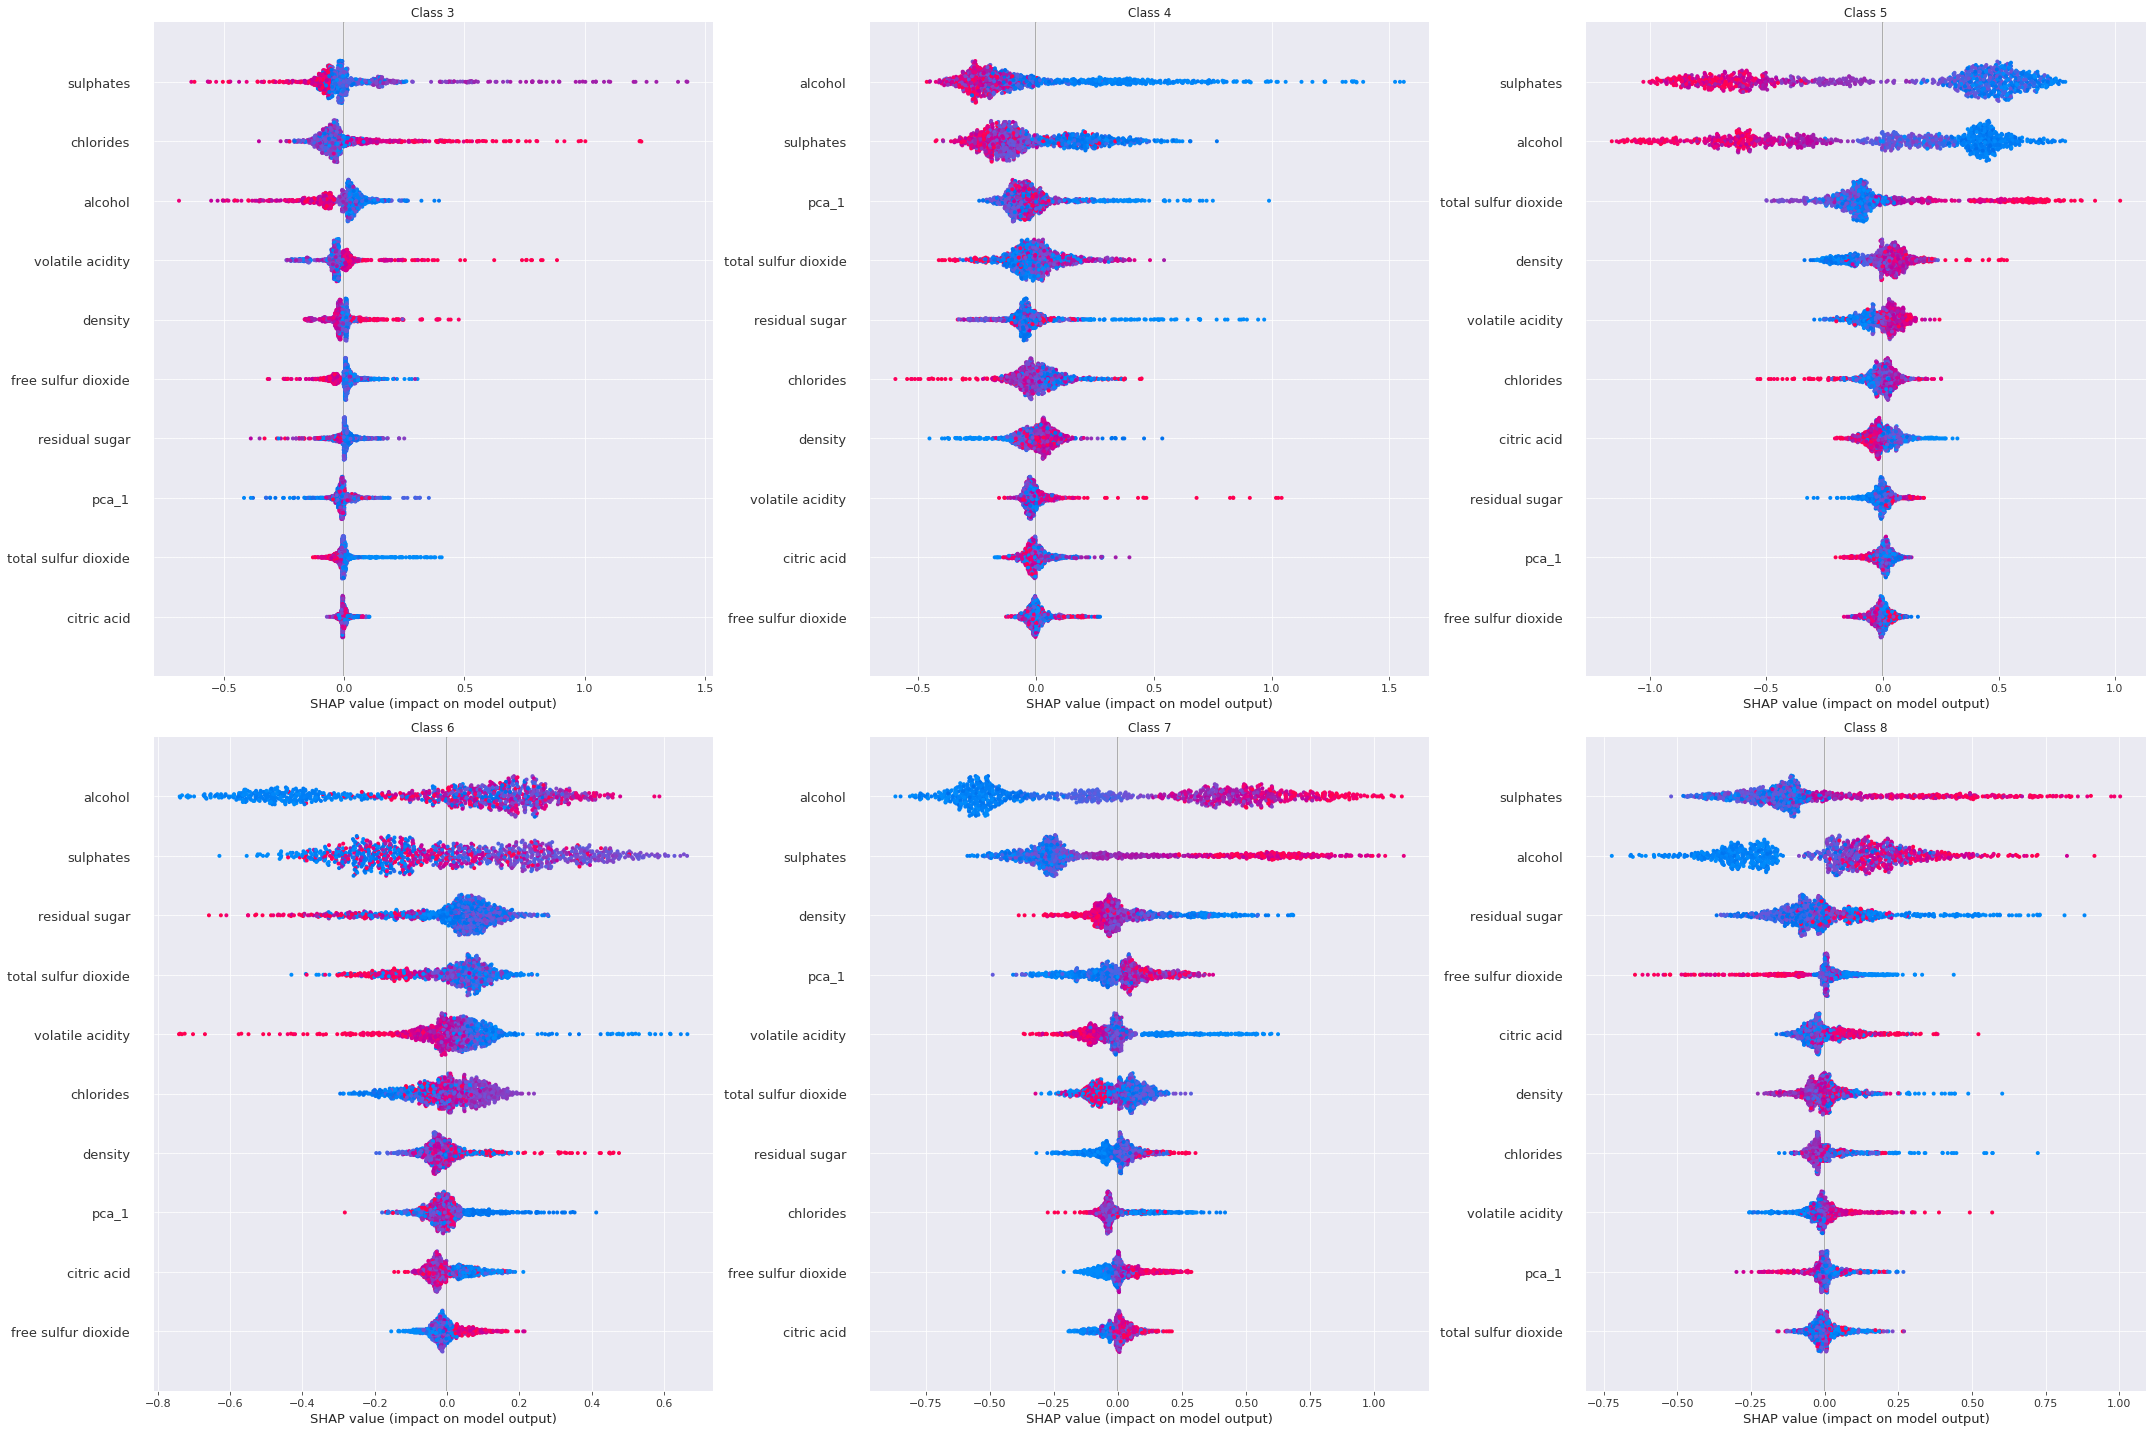

In [46]:
fig = plt.figure()
for i in range(len(df_trn[target].unique())):
    ax = fig.add_subplot(231+i)
    shap.summary_plot(shap_values[i], X_test_s,max_display = 400, show= False, color_bar = False)
    ax.set_title(f"Class {i+3}", fontsize =12)
    
plt.gcf().set_size_inches(30,20)
plt.tight_layout()
plt.show()

### Force Plot


In [47]:
shap.force_plot(explainer.expected_value[1], shap_values[0][0:1,:], X_test_s.iloc[0:1,:])

In [48]:
shap.force_plot(explainer.expected_value[1], shap_values[0], X_test_s)

## Feature Interaction / Feature Dependency </span>
    

#### Interaction Values
Shap Interaction values are the fantastic as visualizing how features affect others in relation to the models prediction 

In [49]:
# Get interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test_s)

### 1. Heatmap plot of shap interaction values 



#### 1a Absolute mean shap interactions 

In [50]:
# Get absolute mean of matrices
abs_mean_shap = np.abs(shap_interaction_values).mean(axis =1)

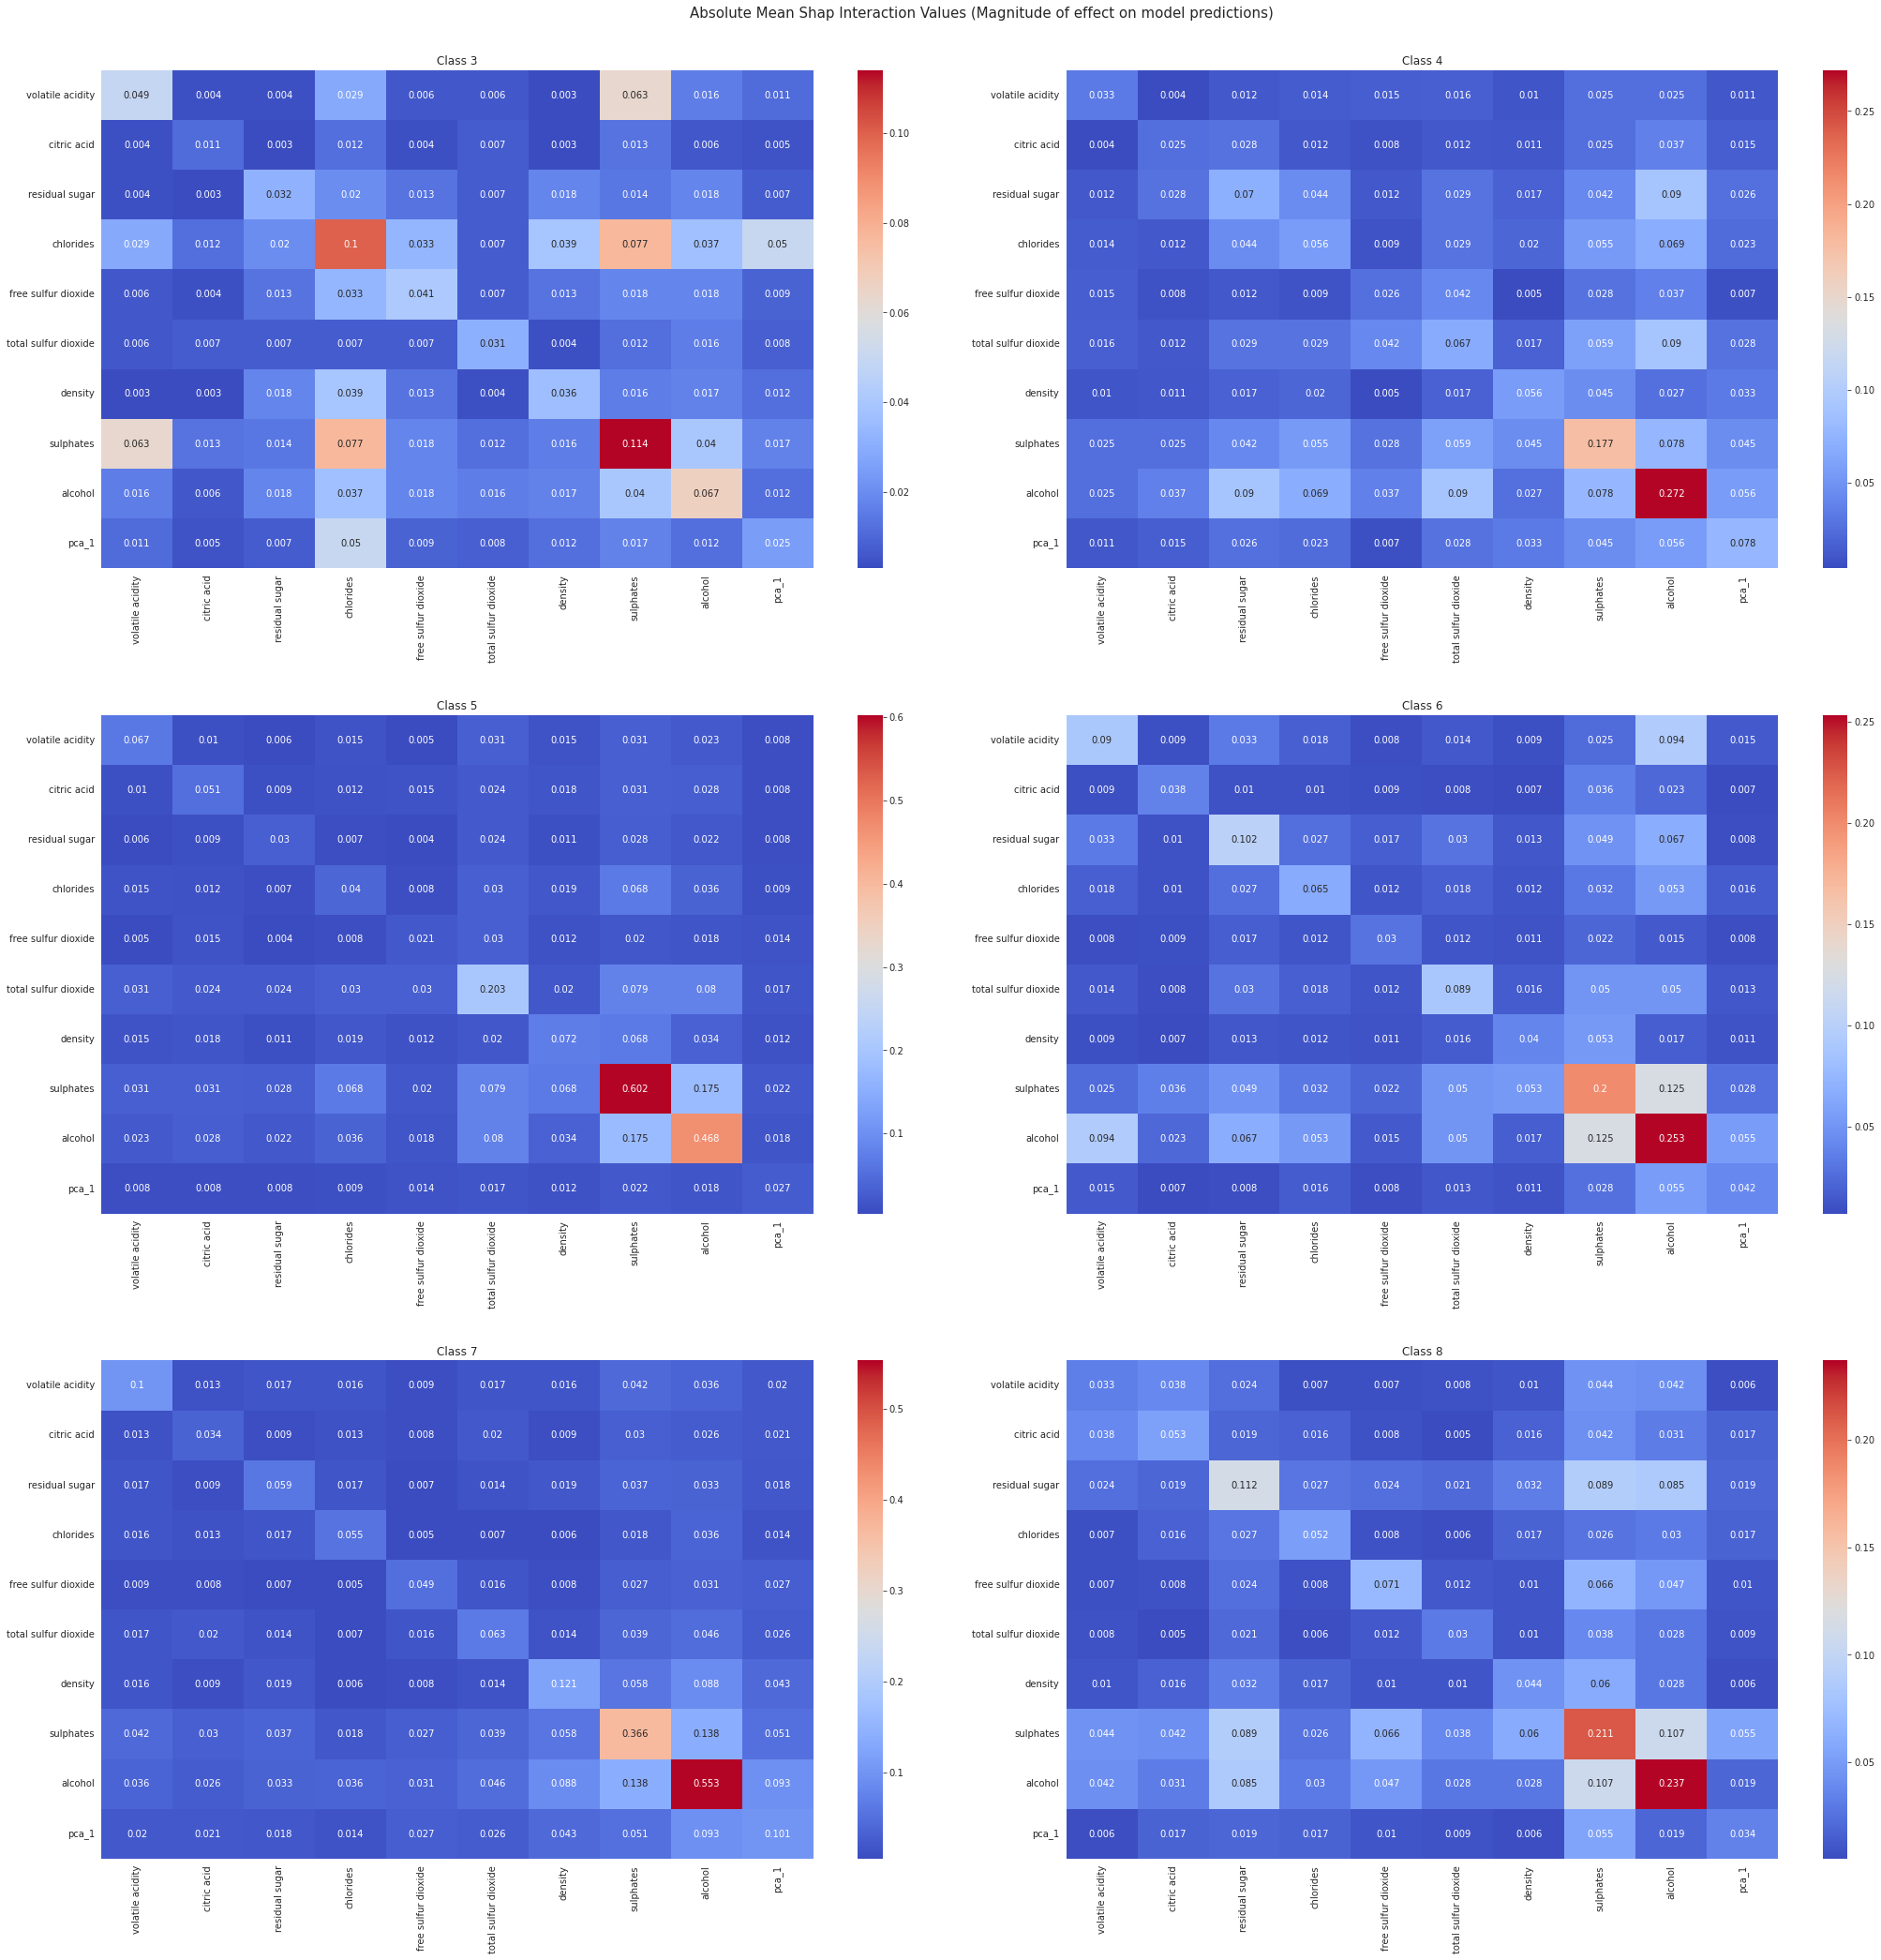

In [51]:
fig,ax = plt.subplots(3,2, figsize = (30, 30)) 
ax = np.ravel(ax)

for i in range(len(abs_mean_shap)):
    df = pd.DataFrame(abs_mean_shap[i], index=X_test_s.columns, columns=X_test_s.columns)
    df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
    sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True, ax=ax[i]   )
    
    ax[i].tick_params(axis='x', labelsize=10, rotation=90)
    ax[i].tick_params(axis='y',  labelsize=10)
    ax[i].set_title(f"Class {i+3}")
plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

#### 1b Mean shap interactions 

In [52]:
# Get absolute mean of matrices
mean_shap = np.array(shap_interaction_values).mean(axis =1)

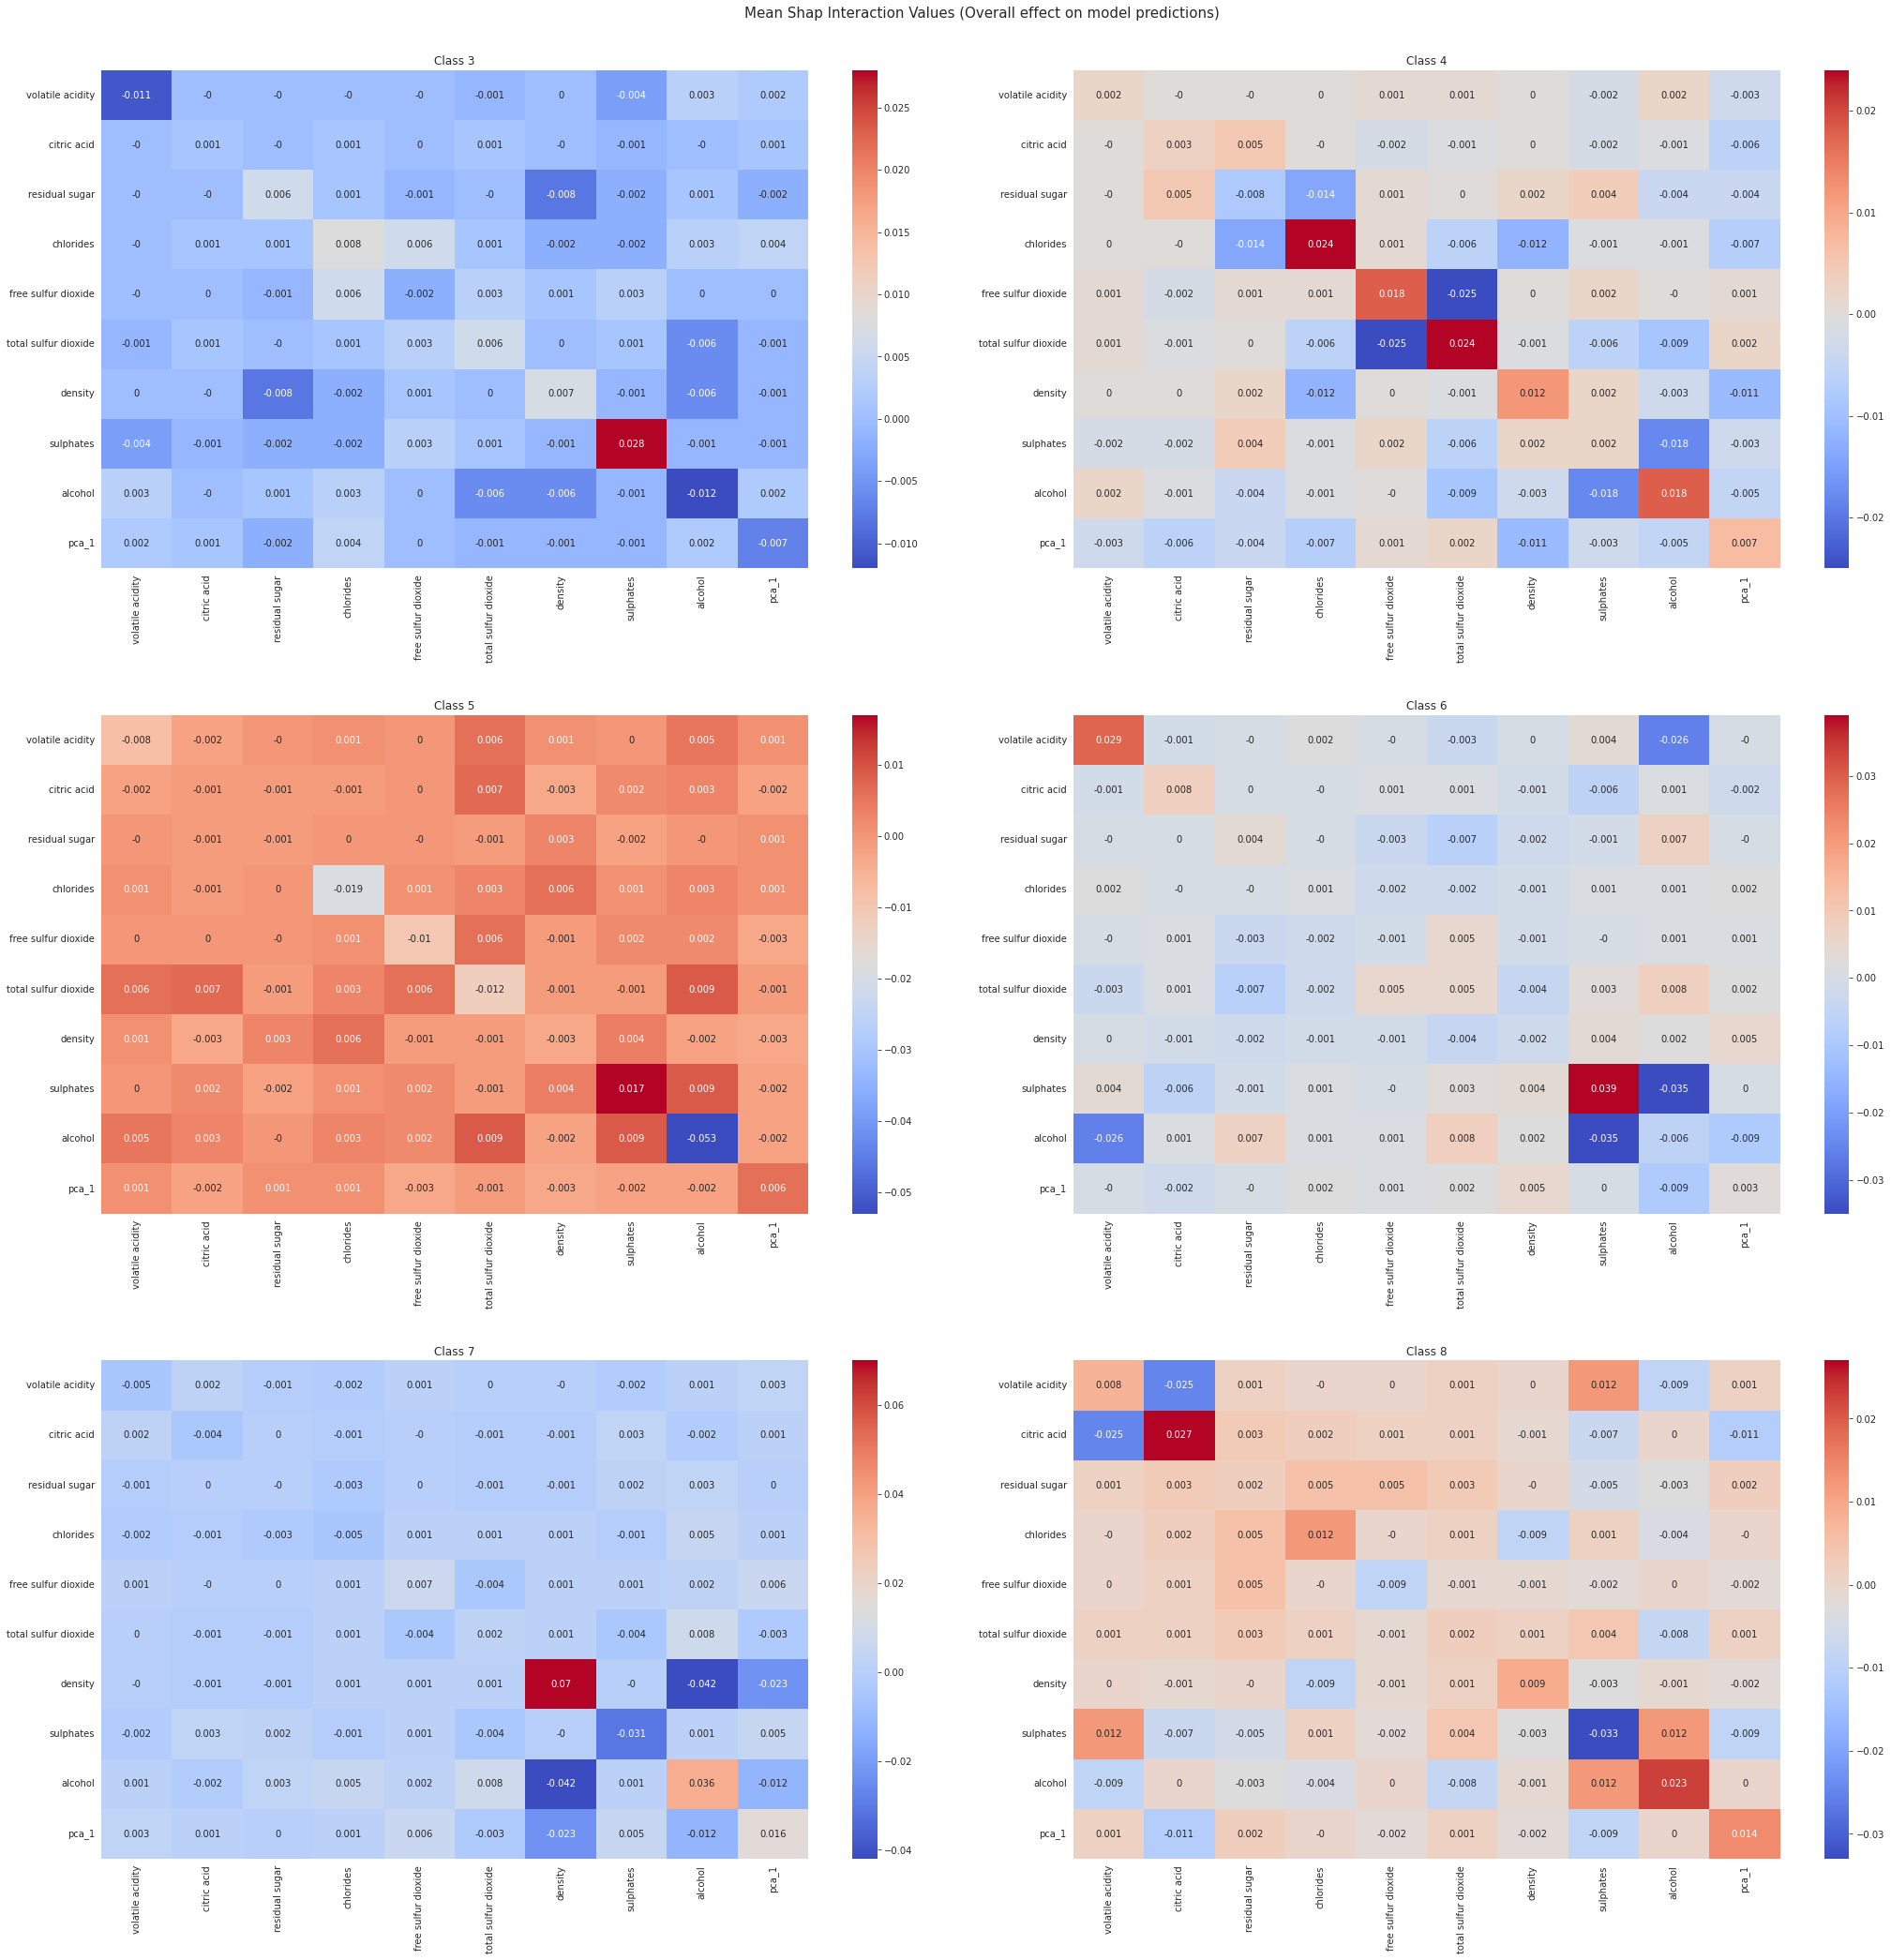

In [53]:
fig,ax = plt.subplots(3,2, figsize = (30, 30)) 
ax = np.ravel(ax)

for i in range(len(mean_shap)):
    df = pd.DataFrame(mean_shap[i], index=X_test_s.columns, columns=X_test_s.columns)
    df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
    sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True, ax=ax[i]   )
    
    ax[i].tick_params(axis='x', labelsize=10, rotation=90)
    ax[i].tick_params(axis='y',  labelsize=10)
    ax[i].set_title(f"Class {i+3}")
plt.suptitle("Mean Shap Interaction Values (Overall effect on model predictions)",fontsize=15)
plt.tight_layout(pad = 4)
plt.show()

#### Dependence plots


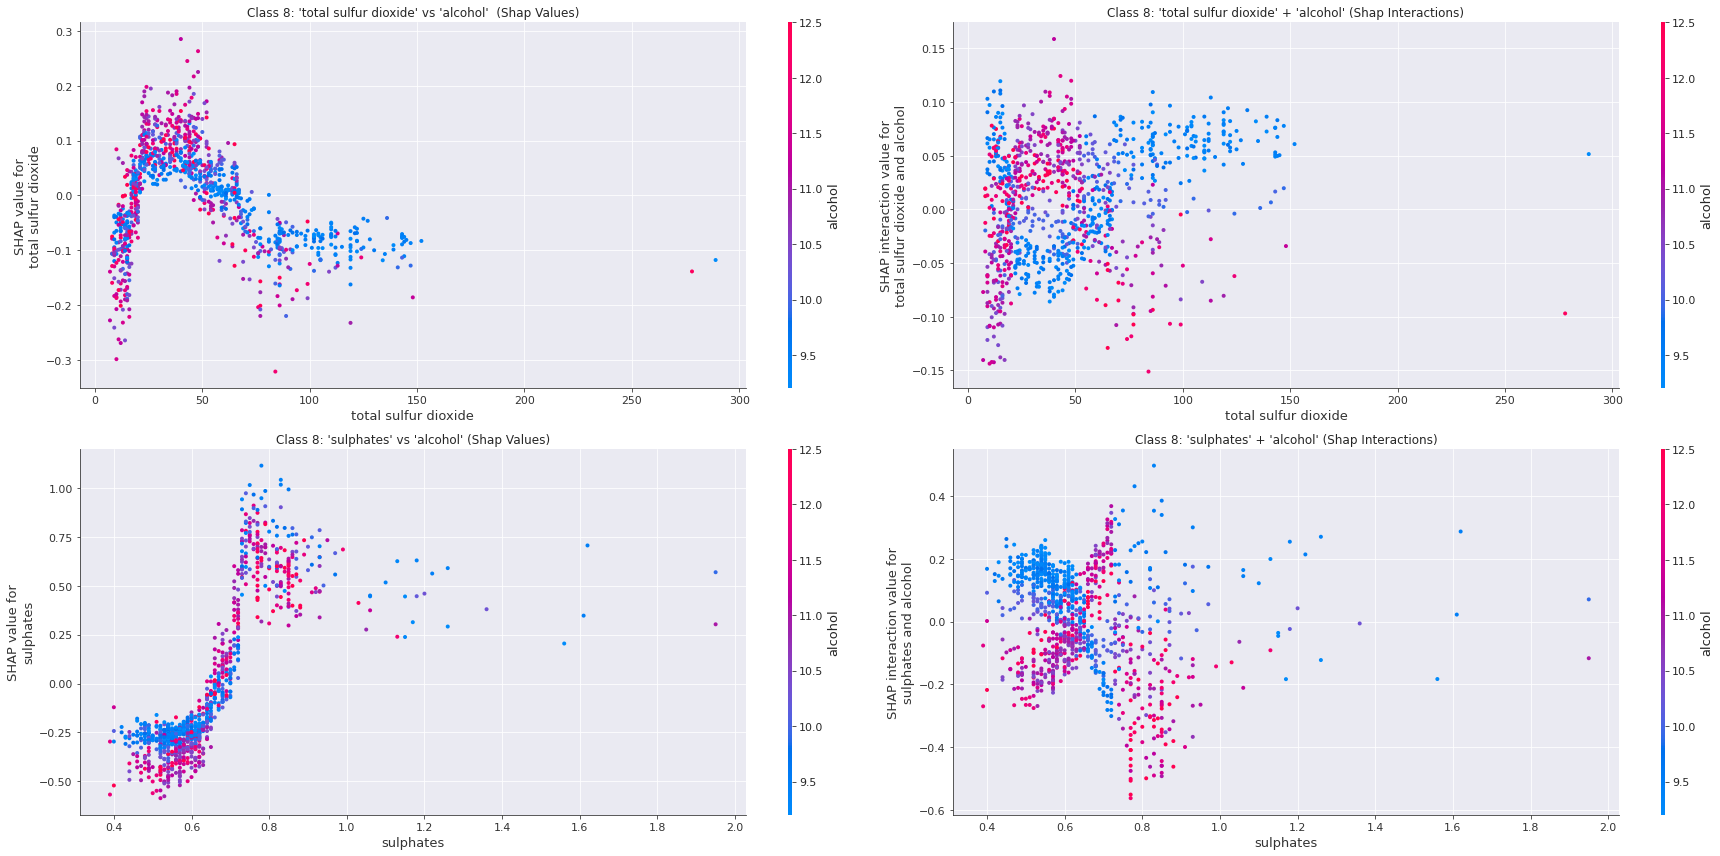

In [54]:
fig = plt.figure()
ax0 = fig.add_subplot(2,2,1)
shap.dependence_plot("total sulfur dioxide", shap_values[4], X_test_s, display_features=X_test_s, interaction_index="alcohol", show=False,ax= ax0)
ax0.set_title("Class 8: 'total sulfur dioxide' vs 'alcohol'  (Shap Values)" )
ax1 = fig.add_subplot(2,2,2)
shap.dependence_plot( ( "total sulfur dioxide","alcohol"),  shap_interaction_values[4], X_test_s, display_features=X_test, show=False, ax= ax1)
ax1.set_title("Class 8: 'total sulfur dioxide' + 'alcohol' (Shap Interactions)" )

ax2 = fig.add_subplot(2,2,3)
shap.dependence_plot("sulphates", shap_values[4], X_test_s, display_features=X_test_s, interaction_index="alcohol", show=False,ax= ax2)
ax2.set_title("Class 8: 'sulphates' vs 'alcohol' (Shap Values)" )
ax3 = fig.add_subplot(2,2,4)
shap.dependence_plot(  ("sulphates","alcohol"),  shap_interaction_values[4], X_test_s, display_features=X_test, show=False, ax= ax3)
ax3.set_title("Class 8: 'sulphates' + 'alcohol' (Shap Interactions)" ) 

plt.gcf().set_size_inches(25,12)
plt.tight_layout()
plt.show()

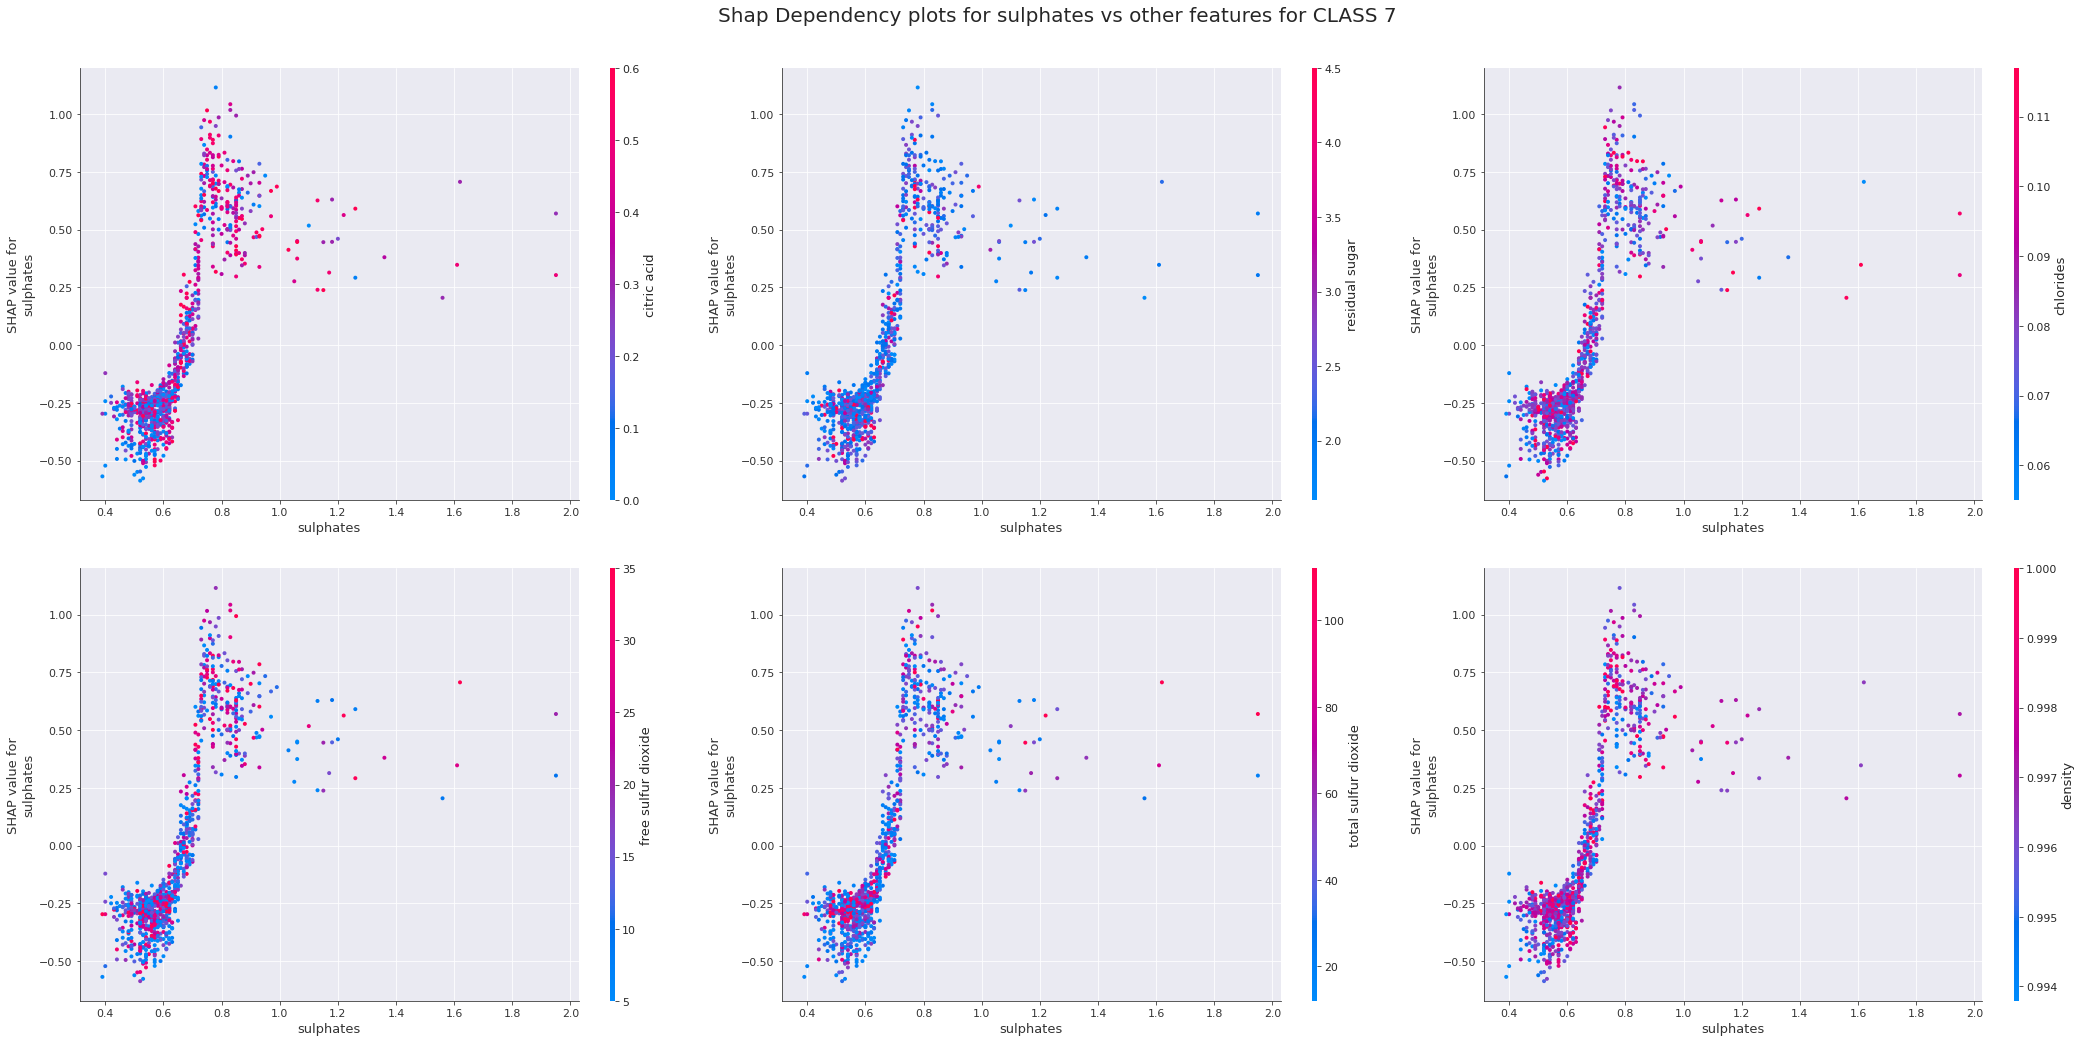

In [55]:
fig = plt.figure()
for i in range(1,7):
    axes = fig.add_subplot(2,3,i)
    shap.dependence_plot("sulphates", shap_values[4], X_test_s, display_features=X_test_s, interaction_index=i, show=False,ax= axes)
plt.gcf().set_size_inches(30,15)
fig.suptitle("Shap Dependency plots for sulphates vs other features for CLASS 7", fontsize = 20)
plt.tight_layout(pad =3)
plt.show()

# Muti-Model Testing 


In [56]:
def Scaling(X_train, X_test, test_df,  y_train, X= None,) : 
    
    """Scaling and Sampling Helper function: 
        Scales and oversamples training and validation dataframes 
    
    :param 
        X_train: pandas dataframe of training data , less target values
        X_test: pandas dataframe of validation data , less target values
        test_df: pandas dataframe of test data , less target values
        y_train: pandas dataframe or series of target training values
        X: pandas dataframe of training and validation data, less target values
        
    :return: scaled input paramaters as pandas dataframes 

    """
    
    test_s = test_df.copy(deep = True)
    X_train_s = X_train.copy(deep = True)
    X_test_s = X_test.copy(deep = True)
    
    if X is not None:
        X_s = X.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        test_s[outliers] = scaler.transform(test_s[outliers])
        if X is not None:
            X_s[outliers] = scaler.transform(X_s[outliers])
    
    if DISTRIBUTION:
        #Scale Skewness: see distribution
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s[non_dist_cols] = scaler.fit_transform(X_train_s[non_dist_cols])
        X_test_s[non_dist_cols] = scaler.transform(X_test_s[non_dist_cols])
        test_s[non_dist_cols] = scaler.transform(test_s[non_dist_cols])
        if X is not None:
            X_s[non_dist_cols] = scaler.transform(X_s[non_dist_cols])
            
    if SCALING: 
        scaler = StandardScaler()
        X_train_s[scaled_cols] = scaler.fit_transform(X_train_s[scaled_cols])
        X_test_s[scaled_cols] = scaler.transform(X_test_s[scaled_cols])
        test_s[scaled_cols] = scaler.transform(test_s[scaled_cols])
        if X is not None:
            X_s[scaled_cols] = scaler.transform(X_s[scaled_cols])
            
    if SMOTE_over:
        smt = SMOTE()
        X_train_s, y_train_s = smt.fit_resample(X_train_s, y_train)
    else:
        y_train_s = y_train.copy(deep= True)
              
    if X is not None:
        return pd.DataFrame(X_train_s, columns = X.columns )   , pd.DataFrame(X_test_s, columns = X.columns ) , pd.DataFrame(test_s, columns = test_df.columns ) , pd.DataFrame(X_s, columns = X.columns ),  y_train_s  
    else:
        return pd.DataFrame(X_train_s, columns = X.columns ), pd.DataFrame(X_test_s, columns = X.columns )  , pd.DataFrame(test_s, columns = test_df.columns ), y_train_s

In [57]:
weights = df_trn[target].value_counts().sort_index()
weights = weights.astype(float)
for i in range(len(weights)):
    #weights[i] = len(df_trn) / (len(weights) * weights[i])
    weights[i] = 1-  (weights[i] / len(df_trn))
weights= weights.to_dict()
print("Catboost class weights:\n")
weights

Catboost class weights:



{0: 0.9941444372153546,
 1: 0.9713728041639558,
 2: 0.5862068965517242,
 3: 0.6138581652569941,
 4: 0.8519843851659076,
 5: 0.9824333116460637}

In [58]:
xgb_params = { 
    'objective' : "multi:softproba",
    'num_class' : 6,
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    #'custom_metric':kappa_score,
    #'scale_pos_weight':weights
             }
cat_params = {'iterations':EPOCHS,
               'class_weights' : weights,
              #'eval_metric' : kappa_score,  ## Need to fix this doesnt work 
              'learning_rate': 0.01,
              'loss_function':'MultiClass'
             }
ET_params = {'max_depth':6, 'num_iterations':EPOCHS}
RF_params = {'class_weight' : 'balanced',  'max_depth':8,'n_estimators':EPOCHS,
            }

In [59]:
# Comment out the models below to include in the Crossvalidation 

models = {
      "LogisticRegression": LogisticRegression(max_iter = EPOCHS),
    "SVC":SVC(probability=True, kernel = "rbf",class_weight='balanced',max_iter = EPOCHS),
     "lightgbm": lgb.LGBMClassifier(**lgb_params), 
    "xgboost": xgb.XGBClassifier(**xgb_params), 
    "catboost": cat.CatBoostClassifier(**cat_params),
     "ExtraTreeClassifier": ExtraTreesClassifier(),
     "RandomForestClassifier":RandomForestClassifier(**RF_params)
}

## Cross Validation

In [60]:
# We use Stratified Kfold due to the class imbalance
kfold= StratifiedKFold(n_splits=5)

In [62]:
test_preds =[]
train_preds = []
val_preds = []
model_shap_values = []

OOF_val_score =[]
OOF_val_loss =[]

for name,model in models.items():
    score_train = []
    score_val= []
    score_loss = []
    
    #Shap stuff
    list_shap_values = []
    val_index = []
    
    in_fold_trn_preds = []   
    in_fold_val_preds= []
    in_fold_preds = []
    print("\n######",name,"######")

    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
        val_index.extend(val_idx)
        
        #Scaling
        if name in ["LogisticRegression",'Ridge', "SVC"]:
            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s  = scaler.transform(X_test)
            X_temp = X.copy(deep = True)
            X_temp = scaler.transform(X_temp)
            test_temp = scaler.transform(df_tst)
            y_train_s = y_train.copy(deep = True)
        else:
            X_train_s, X_test_s , test_temp, X_temp, y_train_s = Scaling(X_train, X_test , df_tst, y_train, X )
            
                   
        #Fit
        if name in ["lightgbm"]:
            model.fit(X_train_s,y_train_s,
                      eval_set=[(X_test_s,y_test)],
                      eval_metric=kappa_score,
                      callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])
            
        if name in ["xgboost"]:
            model.fit(X_train_s,y_train_s,
                     eval_set=[(X_test_s,y_test)],
                      verbose= 0
                     )
        elif name in ["catboost"]:
            model.fit(X_train_s,y_train_s,
                      eval_set=[(X_test_s,y_test)],
                      #eval_metric=kappa_score(),
                      early_stopping_rounds=30,
                      verbose= 0
                     )          
        else:
            model.fit(X_train_s,y_train_s)
            
        # Predict
        y_preds = model.predict_proba(X_test_s)
        val_score= cohen_kappa_score(y_test, y_preds.argmax(axis =1), weights ='quadratic' )
        in_fold_val_preds.extend(y_preds)
        
        #remove low scoring models 
        if val_score >THRESHOLD:
            y_trn_preds = model.predict_proba(X_temp)
            score_val.append(val_score)
            score_train.append(cohen_kappa_score(y, y_trn_preds.argmax(axis =1), weights ='quadratic'))
            score_loss.append(log_loss(y_test, y_preds))
            in_fold_trn_preds.append(y_trn_preds )
            in_fold_preds.append(model.predict_proba(test_temp) )
    
    if len(score_val)>0:
        OOF_val_score.append(np.mean(score_val))
        OOF_val_loss.append(np.mean(score_loss))
        train_preds.append(np.mean(in_fold_trn_preds,axis=0))
        val_preds.append(in_fold_val_preds)
        test_preds.append(np.mean(in_fold_preds,axis=0))

    print("MEAN Trn AUC:",np.mean(score_train))
    print("MEAN Val AUC:",np.mean(score_val))
    print("MEAN logloss:",np.mean(score_loss))


###### LogisticRegression ######
MEAN Trn AUC: 0.4661299312985254
MEAN Val AUC: 0.473999542739676
MEAN logloss: 1.0146071200716908

###### SVC ######
MEAN Trn AUC: 0.5223795084938441
MEAN Val AUC: 0.4721387016660882
MEAN logloss: 1.0203050805264404

###### lightgbm ######
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 1.31958	valid_0's kappa_score: 0.524465
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is s

# Ensembling 

### Mode vs Hard and Soft Voting


In [63]:
# Get a dataframe of train and test predictions 
all_trn_preds = pd.DataFrame(index = df_trn.index)
all_tst_preds = pd.DataFrame(index = df_tst.index)

for i, preds in enumerate(train_preds):
    all_trn_preds[f"{list(models.keys())[i]}_{OOF_val_score[i]}"] = train_preds[i].argmax(axis=1)
    all_tst_preds[f"{list(models.keys())[i]}_{OOF_val_score[i]}"] = test_preds[i].argmax(axis=1)
all_tst_preds = all_tst_preds+3
all_tst_preds

LogisticRegression_0.473999542739676  SVC_0.4721387016660882  \
Id                                                                   
2056                                     5                       5   
2057                                     5                       5   
2058                                     5                       5   
2059                                     6                       6   
2060                                     6                       6   
...                                    ...                     ...   
3423                                     5                       5   
3424                                     7                       6   
3425                                     5                       5   
3426                                     5                       5   
3427                                     5                       5   

      lightgbm_0.46760995461610716  xgboost_0.47132018642542095  \
Id                                                                
2056                             6                            6   
2057                             5                            6   
2058                             6                            6   
2059                             6                            6   
2060                             5                            6   
...                            ...                          ...   
3423                             5                            5   
3424                             7                            7   
3425                             5                            5   
3426                             5                            5   
3427                             5                            5   

      catboost_0.5124243580166289  ExtraTreeClassifier_0.4585557778184711  \
Id                                                                          
2056                            5                                       5   
2057                            6                                       5   
2058                            6                                       6   
2059                            6                                       6   
2060                            6                                       6   
...                           ...                                     ...   
3423                            5                                       5   
3424                            7                                       6   
3425                            5                                       5   
3426                            5                                       5   
3427                            5                                       5   

      RandomForestClassifier_0.5353840249755464  
Id                                               
2056                                          5  
2057                                          6  
2058                                          5  
2059                                          6  
2060                                          6  
...                                         ...  
3423                                          5  
3424                                          7  
3425                                          5  
3426                                          5  
3427                                          5  

[1372 rows x 7 columns]

#### Mode Ensembling

In [82]:
mode_ensemble_trn= y.copy(deep = True)
mode_ensemble_trn= all_trn_preds.mode(axis = 1)[0].values
mode_ensemble_trn = np.round(mode_ensemble_trn).astype('int32')
mode_ensemble_trn = mode_ensemble_trn+3

mode_ensemble[target]= all_tst_preds.mode(axis = 1)[0]
mode_ensemble[target] = np.round(mode_ensemble[target]).astype('int32')

quality
Id           
2056        5
2057        5
2058        6
2059        6
2060        6
...       ...
3423        5
3424        7
3425        5
3426        5
3427        5

[1372 rows x 1 columns]

#### Soft Voting (Mean) Ensembling

In [75]:
# Get mean probabilities
mean_probs = pd.DataFrame(np.zeros((len(all_tst_preds), 6)))
mean_probs_trn =  pd.DataFrame(np.zeros((len(all_trn_preds), 6)))

for i,preds in enumerate(test_preds):
    mean_probs = mean_probs + test_preds[i]
    mean_probs_trn = mean_probs_trn + train_preds[i]
mean_probs = mean_probs/ len(all_tst_preds.columns)
mean_probs_trn = mean_probs_trn /len(all_tst_preds.columns)
mean_probs

0         1         2         3         4         5
0     0.005941  0.056573  0.443672  0.455111  0.038425  0.002891
1     0.028254  0.024499  0.354533  0.363316  0.141630  0.011703
2     0.011638  0.059416  0.376888  0.423035  0.054789  0.005855
3     0.003201  0.007985  0.088672  0.627047  0.201375  0.058506
4     0.005672  0.047858  0.284571  0.405388  0.172626  0.032625
...        ...       ...       ...       ...       ...       ...
1367  0.007500  0.043350  0.680270  0.223546  0.050001  0.006140
1368  0.006593  0.027467  0.084012  0.404879  0.477870  0.040812
1369  0.027766  0.059355  0.634743  0.246705  0.024248  0.003233
1370  0.011756  0.026965  0.799490  0.135080  0.024251  0.004018
1371  0.014652  0.045032  0.468354  0.312004  0.065920  0.008274

[1372 rows x 6 columns]

In [90]:
# Mean ensemble (train)
mean_ensemble_trn= y.copy(deep = True)
mean_ensemble_trn= mean_probs_trn.idxmax(axis = 1).values
mean_ensemble_trn = mean_ensemble_trn.astype('int32')
mean_ensemble_trn = mean_ensemble_trn+3

# Mean ensemble (test)
mean_ensemble = mean_probs.idxmax(axis = 1).values
mean_ensemble = mean_ensemble.astype('int32')
mean_ensemble = mean_ensemble+3
mean_ensemble

array([6, 6, 6, ..., 5, 5, 5], dtype=int32)

### Hard Voting
Get the max probability accross all model predictions 

In [83]:
argmax_val_trn = []

for row in range(len(y)) :
    max_row_val = 0
    current_argmax = -1   
    #for each row of predictions get the max 
    for m in range(len(train_preds)) :
        #if max is greater that other models find the prediction class
        if max(train_preds[m][row]) > max_row_val:
            current_argmax = np.argmax(train_preds[m][row])
            max_row_val = np.max(train_preds[m][row])
            
    argmax_val_trn.extend([current_argmax])

In [84]:
argmax_val = []

for row in range(len(df_tst)) :
    max_row_val = 0
    current_argmax = -1   
    #for each row of predictions get the max 
    for m in range(len(test_preds)) :
        #if max is greater that other models find the prediction class
        if max(test_preds[m][row]) > max_row_val:
            current_argmax = np.argmax(test_preds[m][row])
            max_row_val = np.max(test_preds[m][row])
            
    argmax_val.extend([current_argmax])

In [ ]:
hard_ensemble[target] = argmax_val
hard_ensemble= hard_ensemble+3
hard_ensemble.to_csv("hard_ensemble.csv")
hard_ensemble

## Weighted Ensembling
* Multiple the predictions by their relative score (wieght) and divide by the sum of the scores 
* In this notebook I will focus on **weighted ensembling** as this usually gets decent results for very little coding

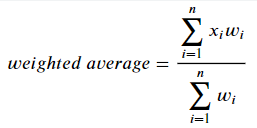

In [ ]:
sub_ensemble_trn = y.copy(deep = True)

for i, preds in enumerate(test_preds):
    sub_ensemble[target] = sub_ensemble[target] + (test_preds[i].argmax(axis=1) * OOF_val_score[i]) #multiply preds by their corresponding auc score
    sub_ensemble_trn= sub_ensemble_trn + (train_preds[i].argmax(axis=1) * OOF_val_score[i])
    
sub_ensemble_trn =   (sub_ensemble_trn/ sum(OOF_val_score) ).values
sub_ensemble_trn = np.round(sub_ensemble_trn).astype('int32')
sub_ensemble_trn= sub_ensemble_trn+3

sub_ensemble[target] =   (sub_ensemble[target]/ sum(OOF_val_score)).values 
sub_ensemble[target] = np.round(sub_ensemble[target]).astype('int32')
sub_ensemble= sub_ensemble+3